# The profiling the evolutionary trajectory or rifampicin resistance and compensation
This notebook outlines the analyses presented in the paper **Expression dysregulation as a mediator of fitness costs in antibiotic resistance**.

**ABSTRACT**

Antimicrobial resistance (AMR) poses a threat to global health and the economy. Rifampicin-resistant *Mycobacterium tuberculosis* accounts for a third of the global AMR burden. Gaining the upper hand on AMR requires a deeper understanding of the physiology of resistance. AMR often results in a fitness cost in absence of drug. Identifying the molecular mechanisms underpinning this cost could help strengthen future treatment regimens. Here, we used a collection of *M. tuberculosis* strains providing an evolutionary and phylogenetic snapshot of rifampicin resistance, and subjected them to genome-wide transcriptomic and proteomic profiling to identify key perturbations of normal physiology. We found that the clinically most common rifampicin resistance-conferring mutation RpoB Ser450Leu imparts considerable gene expression changes, many of which are mitigated by the compensatory mutation in RpoC Leu516Pro. However, our data also provide evidence for pervasive epistasis: the same resistance mutation imposed a different fitness cost and functionally distinct changes to gene expression in genetically unrelated clinical strains. Finally, we report a likely post-transcriptional modulation of gene expression that is shared in most of the tested strains carrying RpoB Ser450Leu, resulting in an increased abundance of proteins involved in central carbon metabolism. These changes contribute to a more general trend, in which the disruption of the composition of the proteome correlates with the fitness cost of the RpoB Ser450Leu mutation in different strains.

## Set up kernel

In [1]:
#Python core packages
from collections import Counter
import string
import pickle
import datetime
import warnings
import os
warnings.filterwarnings("ignore")

#Additional Python packages
import tqdm
import requests as rq

#Scientific packages
from scipy import stats as ss
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import utils as sku
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import networkx as nx

mpl.style.use('classic')
mpl.rcParams['font.family']='Arial'
mpl.rcParams['legend.numpoints'] = 1

%matplotlib inline

axis_size = text_size = 14
label_size = title_size = 18

## Growth Curve Analysis

Start by checking whether the rpoB mutation is costly and that passaging alleviated the cost of resistance. Will use linear regression to do this.

In [2]:
#IMPORT GROWTH CURVE DATA
GC_df = pd.read_csv('../data/Growth_Curves/EVOLUTION_SET_GROWTH_CURVES.csv',index_col=0) #collated growth curves - EVOLUTION SET

GC_df.head()

,STRAIN,SAMPLE_ID,OD600,TIME,log2OD,EVOLVED
0,N0155,N0155_81,0.12,100.0,-3.058894,0
1,N0155,N0155_81,0.27,124.5,-1.888969,0
2,N0155,N0155_81,0.60,147.0,-0.736966,0
3,N0155,N0155_82,0.10,100.0,-3.321928,0
4,N0155,N0155_82,0.23,124.5,-2.120294,0


Run a mixed model linear regression to determine the growth paramaters for **DS** (N0155) and **RifR** (N1981) to identify the relative fitness of the rpoB mutant.

In [3]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*STRAIN', 
                                data=GC_df[GC_df.EVOLVED==0], 
                                groups=GC_df.SAMPLE_ID[GC_df.EVOLVED==0])
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log2OD  
No. Observations:     104        Method:                REML    
No. Groups:           31         Scale:                 0.0197  
Min. group size:      1          Likelihood:            -24.9024
Max. group size:      5          Converged:             Yes     
Mean group size:      3.4                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -7.603    0.229 -33.134 0.000 -8.053 -7.154
STRAIN[T.N1981]       0.243    0.321   0.756 0.450 -0.387  0.872
TIME                  0.042    0.001  48.403 0.000  0.040  0.044
TIME:STRAIN[T.N1981] -0.011    0.001  -9.970 0.000 -0.013 -0.009
Group Var             0.541    1.224                            



In [4]:
print('Relative fitness of the rpoB mutant in N0155: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:STRAIN[T.N1981]'])/result.params['TIME'])*100))

Relative fitness of the rpoB mutant in N0155: 73.6%


In [5]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*STRAIN', 
                                data=GC_df[GC_df.EVOLVED==1], 
                                groups=GC_df.SAMPLE_ID[GC_df.EVOLVED==1])
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log2OD  
No. Observations:     63         Method:                REML    
No. Groups:           18         Scale:                 0.0224  
Min. group size:      3          Likelihood:            -13.4197
Max. group size:      4          Converged:             Yes     
Mean group size:      3.5                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -8.487    0.254 -33.430 0.000 -8.984 -7.989
STRAIN[T.N1589]      -0.490    0.406  -1.206 0.228 -1.286  0.306
TIME                  0.028    0.001  32.142 0.000  0.027  0.030
TIME:STRAIN[T.N1589] -0.000    0.001  -0.235 0.814 -0.003  0.002
Group Var             0.216    0.623                            



In [6]:
print('Relative fitness of rpoB mutant in evolved background: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:STRAIN[T.N1589]'])/result.params['TIME'])*100))

Relative fitness of rpoB mutant in evolved background: 98.8%


Based on these it is clear that the cost of the *rpoB* mutation is compensated by the presence of the *rpoC* in the N0155 background.

We can therefore try to compare the expression profile of the strains to identify a signature of resistance.

## Expression analysis for the EVOLUTION SET

### Load RNAseq and SWATH MS data

In [7]:
#Set up scripts and go to data module
%run ../src/TbX_module_ver1.py
%cd ../data/RNAseq/

genes_df = pd.read_csv('EVOLUTION_SET_compensation_genesets.csv', index_col=0)

#EVOLUTION SET [TbX008]
#Import RNAseq data
tbx8 = Bunch()
tbx8.import_dataset('EVOLUTION_SET_rnaseq_samples.txt', N=12)
tbx8.import_knowledge()
tbx8['name'] = ['DS',]*3+['RifR',]*3+['DSevo',]*3+['RifRevo',]*3

#Import results of DESeq2 analysis (record kept in /src/DESeq/1_RpoB_pairwise_analysis.R)
#N0155 vs N1981
tbx8.import_DEcsv('./DESeq_EVOLUTION_SET_rif_RS.csv', DEtype='DESeq2')
#N0155 vs N1589
tbx8.import_DEcsv('./DESeq_EVOLUTION_SET_rif_wt_rpoBE.csv',label='DEvo',DEtype='DESeq2')
#N1981 vs N1589
tbx8.import_DEcsv('./DESeq_EVOLUTION_SET_comp_rpoBrpoBE.csv',label='comp', DEtype='DESeq2')
#N1588 vs N1589
tbx8.import_DEcsv('./DESeq_EVOLUTION_SET_rif_wtE_rpoBE.csv',label='evol', DEtype='DESeq2')

#Signature of compensation [DESeq2]
#RifR vs Rest
tbx8.import_DEcsv('./DESeq_EVOLUTION_SET_compensation.csv',label='DEcomp', DEtype='DESeq2')

C:\Users\Andrej Trauner\Documents\STPH\Current\Cost_of_resistance\cost-of-resistance\data\RNAseq


In [8]:
#EVOLUTION_SET [TbX008]
#Import proteome data
tbx8p = Bunch()
for x in tbx8.categories:
    tbx8p[x] = tbx8[x]
tbx8p['sample'] = ['TbX008_P0155_3_3', 'TbX008_P0155_5_3', 'TbX008_P0155_7_3', 'TbX008_P1588_1_3',
                   'TbX008_P1588_10_3', 'TbX008_P1588_4_3', 'TbX008_P1588_6_3', 'TbX008_P1589_1_3',
                   'TbX008_P1589_3_3', 'TbX008_P1589_5_3', 'TbX008_P1589_7_3', 'TbX008_P1981_1_3',
                   'TbX008_P1981_3_3', 'TbX008_P1981_7_3']
tbx8p['name'] = ['DS',]*3+['DSevo',]*4+['RifRevo',]*4+['RifR',]*3

tbx8p.import_dataset('../Proteome/EVOLUTION_SET_SWATH_MS_dataframe.txt', N=14, format='proteome')

#Import results of MSstats analysis
#N0155 vs N1981
tbx8p.import_DEcsv('../Proteome/MSstats_EVOLUTION_SET_rpoBwt.tsv',label='MSstats', DEtype='MSstats')
#N1589 vs N1981
tbx8p.import_DEcsv('../Proteome/MSstats_EVOLUTION_SET_rpoBCrpoB.tsv',label='comp', DEtype='MSstats')
#N1589 vs N0155
tbx8p.import_DEcsv('../Proteome/MSstats_EVOLUTION_SET_rpoBCwt.tsv',label='DEvo', DEtype='MSstats')
#N1589 vs N1588
tbx8p.import_DEcsv('../Proteome/MSstats_EVOLUTION_SET_rpoBCwtE.tsv',label='evol', DEtype='MSstats')

#Signature of compensation [MSstats]
#RifR vs Rest MSstats
tbx8p.import_DEcsv('../Proteome/MSstats_EVOLUTION_SET_compensation.tsv',label='compsig', DEtype='MSstats')

Trying to load the knowledge


Calculate the number of Transcripts per kilobase million (TPM) for the data. THese can be considered as a proxy for absolute transcript quantifications. First define the function

In [9]:
def CalculateTPM(bunch,trim=True):
    """Calculate TPMs for a set of reads.
    
    INPUT:
    ------
    bunch: dataset
    trim: indices to remove from data (deafult behaviour for TbX dataset)
    
    OUTPUT:
    -------
    np.ndarray containing TPM
    """
    
    #generate copy of count data
    _recipient = np.zeros(np.shape(bunch['data']))+bunch['data']
    
    #trim data if necessary
    if trim:
        _recipient = _recipient[:-50,:]
    
    #get gene sizes from knowledge
    _gene_sizes = np.array([int(bunch['knowledge'][x][2]) for x in bunch['genes'] if x in bunch['knowledge']])
    
    #normalise counts by gene size
    _sized_counts = (_recipient.T/_gene_sizes).T
    
    #calcualte TPM
    _tpm = _sized_counts/(np.sum(_sized_counts, axis=0)/1e6)
    
    return _tpm

Next, calculate the value of the TPM and append to the tbx8 data. We will use these for overview stats.

In [10]:
tbx8['TPM'] = CalculateTPM(tbx8)

## Overview of EVOLUTION SET expression data

### Hierarchical clustering for the data

In [11]:
#import Hierarchical clustering submodule from SciPy
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

In [12]:
#generate the linkage matrices
RNASEQ_LINKAGE = hierarchy.linkage(tbx8.TPM.T, 'ward')
PROTEOME_LINKAGE = hierarchy.linkage(tbx8p.data.T, 'ward')

print(hierarchy.cophenet(RNASEQ_LINKAGE, pdist(tbx8.TPM.T))[0])
print(hierarchy.cophenet(PROTEOME_LINKAGE, pdist(tbx8p.data.T))[0])

0.7154601952740842
0.7894531755646741


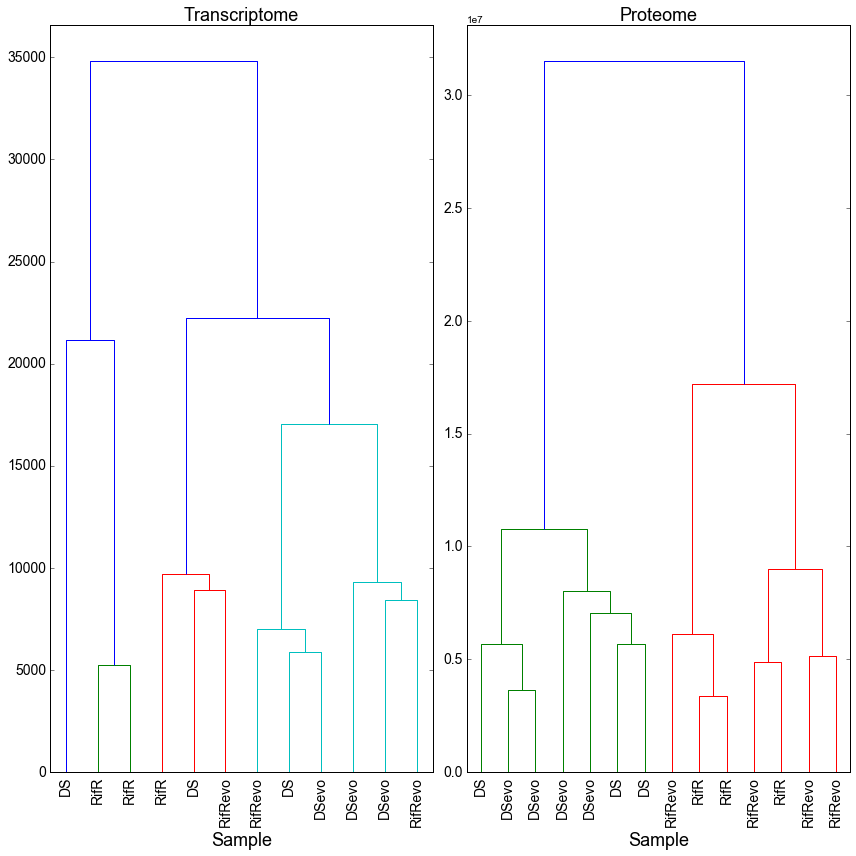

In [13]:
plt.figure(figsize=(12,12))
plt.subplot(121)
hierarchy.dendrogram(RNASEQ_LINKAGE, leaf_rotation=90, 
                     leaf_font_size=axis_size, labels=tbx8.name, 
                     color_threshold=20000,)
plt.xlabel('Sample', size=label_size)
plt.yticks(size=axis_size)
plt.title('Transcriptome', size=18)
plt.subplot(122)
hierarchy.dendrogram(PROTEOME_LINKAGE, leaf_rotation=90, 
                     leaf_font_size=axis_size, labels=tbx8p.name, 
                     color_threshold=1.8e7,)
plt.xlabel('Sample', size=label_size)
plt.title('Proteome', size=18)
plt.yticks(size=axis_size)

plt.tight_layout()

plt.show()

The structure for the transcriptome is less makred than for the proteome. The latter seems to split clearly based on the dimension of the presence/absence of the Ser450Leu mutation in RpoB. Let's have a look at what the correlation matrix looks like.

DescribeResult(nobs=144, minmax=(0.9437566089584468, 1.0), mean=0.9781939456309158, variance=0.00017890445570123252, skewness=-0.607020149968037, kurtosis=0.08229292928697518)
Maximum rho:  0.9973949854123315
DescribeResult(nobs=196, minmax=(0.9303891444542375, 1.0), mean=0.971683462865061, variance=0.00028532294135431293, skewness=-0.22839992491145863, kurtosis=-0.7514483587492182)
Maximum rho:  0.9931375757217908


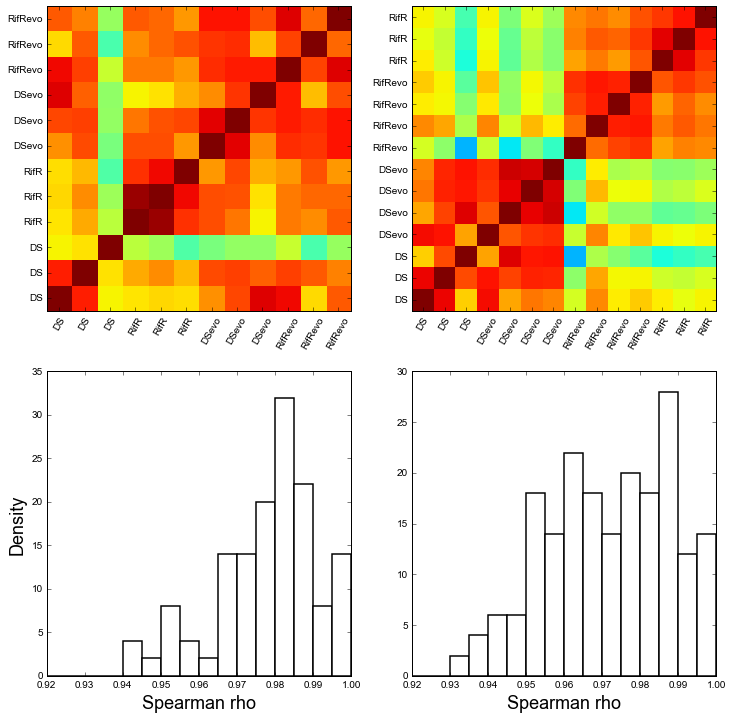

In [14]:
plt.figure('Spearman correlations', figsize=(12,12))
plt.subplot(221)
plt.imshow(ss.spearmanr(tbx8.data)[0],interpolation='none',vmin=0.9,vmax=1.0)
plt.xticks(np.arange(12),tbx8.name, rotation=60)
plt.yticks(np.arange(12),tbx8.name)
plt.ylim(-.5,11.5)
plt.subplot(222)
plt.imshow(ss.spearmanr(tbx8p.data)[0], interpolation='none',vmin=0.9,vmax=1.0)
plt.xticks(np.arange(14),tbx8p.name, rotation=60)
plt.yticks(np.arange(14),tbx8p.name)
plt.ylim(-.5,13.5)
plt.subplot(223)
plt.hist(ss.spearmanr(tbx8.data)[0].flatten(),bins=np.arange(.92,1.005,.005),color='white',lw=1.5)
plt.ylabel('Density', size=label_size)
plt.xlabel('Spearman rho', size=label_size)
plt.subplot(224)
plt.hist(ss.spearmanr(tbx8p.data)[0].flatten(),bins=np.arange(.92,1.005,.005),color='white',lw=1.5)
plt.xlabel('Spearman rho', size=label_size)



print(ss.describe(ss.spearmanr(tbx8.data)[0].flatten()))
print("Maximum rho: ",np.max(ss.spearmanr(tbx8.data)[0].flatten()[ss.spearmanr(tbx8.data)[0].flatten()<0.999]))
print(ss.describe(ss.spearmanr(tbx8p.data)[0].flatten()))
print("Maximum rho: ",np.max(ss.spearmanr(tbx8p.data)[0].flatten()[ss.spearmanr(tbx8p.data)[0].flatten()<0.999]))

The correlations are high [Spearman's rho is between 0.93-0.99 for all samples]. This suggests that the expression changes overall are subtle retaining the broad relationships between expressed genes. The correlation pattern clearly recapitulates the representation from the hierarchical clustering.

### Levels of RNAP expression

We performed differential expression analysis using multiple different comparative approaches. Below we will assess the levels of *rpoA, rpoB and rpoC* gene products both at the level of RNA and protein. These have been shown to be the target for compensation in pseudomonads.

In [15]:
tbx8.DESeq_genes[[679,680,3523]]

array(['Rv0667', 'Rv0668', 'Rv3457c'], dtype='<U8')

In [16]:
print('COMPARISON OF RifR VS DS\n')
for (gene,lfc,pval) in zip(tbx8.DESeq_genes[[679,680,3523]],.5**tbx8.DESeq_data[[679,680,3523]][:,1],tbx8.DESeq_data[[679,680,3523]][:,-1]):
    print(f'{gene} expression is {np.round(lfc,2)} log2-fold different, with a p-value of: {np.round(pval,2)}')
print('\nCOMPARISON OF RifR VS ALL OTHER STRAINS\n')
for (gene,lfc,pval) in zip(tbx8.DEcomp_genes[[679,680,3523]],2**tbx8.DEcomp_data[[679,680,3523]][:,1],tbx8.DEcomp_data[[679,680,3523]][:,-1]):
    print(f'{gene} expression is {np.round(lfc,2)} log2-fold different, with a p-value of: {np.round(pval,2)}')

COMPARISON OF RifR VS DS

Rv0667 expression is 1.05 log2-fold different, with a p-value of: 0.85
Rv0668 expression is 1.03 log2-fold different, with a p-value of: 0.93
Rv3457c expression is 1.05 log2-fold different, with a p-value of: 0.88

COMPARISON OF RifR VS ALL OTHER STRAINS

Rv0667 expression is 0.9 log2-fold different, with a p-value of: 0.62
Rv0668 expression is 0.98 log2-fold different, with a p-value of: 0.95
Rv3457c expression is 0.88 log2-fold different, with a p-value of: 0.76


At the level of transcript there are no significant changes between RifR and any of the other strains. Let's look at protein levels.

In [17]:
print('COMPARISON OF RifR VS DS\n')
for (gene,lfc,pval) in zip(tbx8p.MSstats_genes[[511,512,2556]],.5**tbx8p.MSstats_data[[511,512,2556]][:,1],tbx8p.MSstats_data[[511,512,2556]][:,-1]):
    print(f'{gene} expression is {np.round(lfc,2)} log2-fold different, with a p-value of: {np.round(pval,2)}')
print('\nCOMPARISON OF RifR VS ALL OTHER STRAINS\n')
for (gene,lfc,pval) in zip(tbx8p.compsig_genes[[511,512,2556]],.5**tbx8p.compsig_data[[511,512,2556]][:,1],tbx8p.compsig_data[[511,512,2556]][:,-1]+1):
    print(f'{gene} expression is {np.round(lfc,2)} log2-fold different, with a p-value of: {np.round(pval,2)}')

COMPARISON OF RifR VS DS

Rv0667 expression is 0.93 log2-fold different, with a p-value of: 0.21
Rv0668 expression is 0.93 log2-fold different, with a p-value of: 0.01
Rv3457c expression is 0.96 log2-fold different, with a p-value of: 0.68

COMPARISON OF RifR VS ALL OTHER STRAINS

Rv0667 expression is 0.9 log2-fold different, with a p-value of: 1.0
Rv0668 expression is 0.9 log2-fold different, with a p-value of: 1.0
Rv3459c expression is 0.95 log2-fold different, with a p-value of: 1.0


As for the RNAseq data, proteomic data show no evidence of significant DE of RNAP with the sole difference of a significant, albeit small, decrease of RpoC levels in the RifR vs DS comparison.

Next, let's quatify the impact of RpoB on overall gene expression.

In [18]:
print('RifR vs DS')
print(f'There are {len(tbx8.DESeq_significant)} significantly affected genes ({np.round(len(tbx8.DESeq_significant)/len(tbx8.DESeq_genes),3)*100}%), {np.sum(np.abs(tbx8.DESeq_data[tbx8.DESeq_significant][:,1])>1)} with greater than 2-fold expression change')
print(f'Mean expression change: {np.round(2**np.median(np.abs(tbx8.DESeq_data[tbx8.DESeq_significant][:,1])),2)} IQR: {np.round(2**np.quantile(np.abs(tbx8.DESeq_data[tbx8.DESeq_significant][:,1]),.25),2)}-{np.round(2**np.quantile(np.abs(tbx8.DESeq_data[tbx8.DESeq_significant][:,1]),.75),2)}')
print('\nRifR vs RifRevo')
print(f'There are {len(tbx8.comp_significant)} significantly affected genes ({np.round(len(tbx8.comp_significant)/len(tbx8.comp_genes),3)*100}%), {np.sum(np.abs(tbx8.comp_data[tbx8.comp_significant][:,1])>1)} with greater than 2-fold expression change')
print(f'Mean expression change: {np.round(2**np.median(np.abs(tbx8.comp_data[tbx8.comp_significant][:,1])),2)}, IQR: {np.round(2**np.quantile(np.abs(tbx8.comp_data[tbx8.comp_significant][:,1]),.25),2)}-{np.round(2**np.quantile(np.abs(tbx8.comp_data[tbx8.comp_significant][:,1]),.75),2)}')

RifR vs DS
There are 744 significantly affected genes (18.4%), 73 with greater than 2-fold expression change
Mean expression change: 1.47 IQR: 1.37-1.63

RifR vs RifRevo
There are 541 significantly affected genes (13.5%), 33 with greater than 2-fold expression change
Mean expression change: 1.37, IQR: 1.29-1.5


In [19]:
print('RifR vs DS')
print(f'There are {len(tbx8p.MSstats_significant)} significantly affected genes ({np.round(len(tbx8p.MSstats_significant)/len(tbx8p.MSstats_genes),3)*100}%), {np.sum(np.abs(tbx8p.MSstats_data[tbx8p.MSstats_significant][:,0])>1)} with greater than 2-fold expression change')
print(f'Mean expression change: {np.round(2**np.median(np.abs(tbx8p.MSstats_data[tbx8p.MSstats_significant][:,0])),2)}, IQR: {np.round(2**np.quantile(np.abs(tbx8p.MSstats_data[tbx8p.MSstats_significant][:,0]),.25),2)}-{np.round(2**np.quantile(np.abs(tbx8p.MSstats_data[tbx8p.MSstats_significant][:,0]),.75),2)}')
print('\nRifR vs RifRevo')
print(f'There are {len(tbx8p.comp_significant)} significantly affected genes ({np.round(len(tbx8p.comp_significant)/len(tbx8p.comp_genes),3)*100}%), {np.sum(np.abs(tbx8p.comp_data[tbx8p.comp_significant][:,0])>1)} with greater than 2-fold expression change')
print(f'Mean expression change: {np.round(2**np.median(np.abs(tbx8p.comp_data[tbx8p.comp_significant][:,0])),2)}, IQR: {np.round(2**np.quantile(np.abs(tbx8p.comp_data[tbx8p.comp_significant][:,0]),.25),2)}-{np.round(2**np.quantile(np.abs(tbx8p.comp_data[tbx8p.comp_significant][:,0]),.75),2)}')

RifR vs DS
There are 998 significantly affected genes (34.4%), 176 with greater than 2-fold expression change
Mean expression change: 1.45, IQR: 1.29-1.78

RifR vs RifRevo
There are 317 significantly affected genes (10.9%), 25 with greater than 2-fold expression change
Mean expression change: 1.34, IQR: 1.25-1.5


Overall the impact of these changes is broad but not very high, similar to the data reported for other pleiotropic CarD and RbpA. 

More importantly the impact of resistance outstrips that of compensation. Let's compare the overlap between the differentially expressed genes.

In [20]:
print(
f'Number of genes disrupted by RpoB Ser450Leu: {len(tbx8.DESeq_significant)}'
)

print(
f'Number of genes whose expression is reverted by RpoC Leu516Pro in RpoB Ser450Leu: {len(set(tbx8.comp_significant)&set(tbx8.DESeq_significant))} [{np.round(len(set(tbx8.comp_significant)&set(tbx8.DESeq_significant))/len(set(tbx8.DESeq_significant))*100,1)}%]'
)

Number of genes disrupted by RpoB Ser450Leu: 744
Number of genes whose expression is reverted by RpoC Leu516Pro in RpoB Ser450Leu: 229 [30.8%]


In [21]:
print(
f'Number of proteins disrupted by RpoB Ser450Leu: {len(tbx8p.MSstats_significant)}'
)

print(
f'Number of proteins whose expression is reverted by RpoC Leu516Pro in RpoB Ser450Leu: {len(set(tbx8p.comp_significant)&set(tbx8p.MSstats_significant))} [{np.round(len(set(tbx8p.comp_significant)&set(tbx8p.MSstats_significant))/len(set(tbx8p.MSstats_significant))*100,1)}%]'
)

Number of proteins disrupted by RpoB Ser450Leu: 998
Number of proteins whose expression is reverted by RpoC Leu516Pro in RpoB Ser450Leu: 217 [21.7%]


Compensation is clearly partial on the level of individual genes, let's look on the overall level of gene expression.

## Quantify the extent of compensation

The idea behind this analysis stems from the hypothesis that compensation should return the expression of genes whose levels are affected by RpoB Ser450Leu back to wild type. If this compensation is complete, then comparing the differential expression between RifR/wt and RifR/RifRevo should provide a slope of 1 [i.e. 100% compensation]. If the slope is between 0-1 then that provides an estimate for the overall compesation of expression observed.

In [22]:
#Create recipient for the data
transcriptome = {x:{'RESIST_LFC':0, 'RESIST_P':1.0, 
                    'COMPENSATION_LFC':0, 'COMPENSATION_P':1.0, 
                    'EVOLVED_LFC':0,'EVOLVED_P':1.0,} for x in tbx8.comp_genes}

#Populate the recipient for the data
for ind,val in enumerate(tbx8.comp_genes):
    transcriptome[val]['RESIST_LFC']+=tbx8.DESeq_data[ind,1]
    transcriptome[val]['RESIST_P']=tbx8.DESeq_data[ind,-1]
    transcriptome[val]['COMPENSATION_LFC']+=tbx8.comp_data[ind,1]
    transcriptome[val]['COMPENSATION_P']=tbx8.comp_data[ind,-1]
    transcriptome[val]['EVOLVED_LFC']+=tbx8.evol_data[ind,1]
    transcriptome[val]['EVOLVED_P']=tbx8.evol_data[ind,-1]
    
#Generate a DataFrame
transcript_df = pd.DataFrame(transcriptome).T
#Define the signature of resistance
transcript_df['SIG_RESIST'] = ["NO" for x in tbx8.DESeq_data[:-50,-1]]
transcript_df['SIG_RESIST'][transcript_df.RESIST_P<0.05]="YES"
#Define the singature of compensation
transcript_df['SIG_COMP'] = ["NO" for x in tbx8.DESeq_data[:-50,-1]]
transcript_df['SIG_COMP'][(transcript_df.COMPENSATION_P<0.05)&(transcript_df.RESIST_P<0.05)&(transcript_df.EVOLVED_P>0.05)]="YES"
#Print the head of the new DataFrame
transcript_df.head()

,RESIST_LFC,RESIST_P,COMPENSATION_LFC,COMPENSATION_P,EVOLVED_LFC,EVOLVED_P,SIG_RESIST,SIG_COMP
Rv0001,-0.389934,0.250673,0.023057,0.953070,-0.041985,0.997576,NO,NO
Rv0002,-0.259929,0.243301,-0.084237,0.760274,-0.080694,0.997576,NO,NO
Rv0003,0.055026,0.856738,-0.081181,0.736035,0.080151,0.997576,NO,NO
Rv0004,0.130890,0.615760,-0.041385,0.901846,0.023092,0.997576,NO,NO
Rv0005,-0.101216,0.823844,0.285372,0.011865,0.008067,0.997576,NO,NO


In [23]:
model = sm.OLS.from_formula('COMPENSATION_LFC ~ RESIST_LFC',transcript_df,)
result_transcriptome = model.fit()
print(result_transcriptome.summary())

                            OLS Regression Results                            
Dep. Variable:       COMPENSATION_LFC   R-squared:                       0.363
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     2273.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:01:57   Log-Likelihood:                 508.17
No. Observations:                3997   AIC:                            -1012.
Df Residuals:                    3995   BIC:                            -999.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0206      0.003      6.106      0.0

In [24]:
print(f'The overall impact of compensation: {np.round(result_transcriptome.params[1],3)*100}%')

The overall impact of compensation: 43.0%


In [25]:
model = sm.OLS.from_formula('COMPENSATION_LFC ~ RESIST_LFC*SIG_COMP',transcript_df,)
result_transcriptome = model.fit()
print(result_transcriptome.summary())

                            OLS Regression Results                            
Dep. Variable:       COMPENSATION_LFC   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:                 Least Squares   F-statistic:                     883.2
Date:                Sun, 06 Jun 2021   Prob (F-statistic):               0.00
Time:                        22:01:57   Log-Likelihood:                 625.19
No. Observations:                3997   AIC:                            -1242.
Df Residuals:                    3993   BIC:                            -1217.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [26]:
print(f'The compensated slope is: {np.round(result_transcriptome.params[2]+result_transcriptome.params[3],3)}')

The compensated slope is: 0.607


This basically says that when compensation happens it corrects approximately 61% of the abarrent transcript expression.

In [27]:
#Create recipient for the data
proteome = {x:{'RESIST_LFC':0, 'RESIST_P':1.0, 
               'COMPENSATION_LFC':0, 'COMPENSATION_P':1.0, 
               'EVOLVED_LFC':0,'EVOLVED_P':1.0,} for x in tbx8p.comp_genes}

#Populate the recipient for the data
for ind,val in enumerate(tbx8p.comp_genes):
    proteome[val]['RESIST_LFC']+=tbx8p.MSstats_data[ind,0]
    proteome[val]['RESIST_P']=tbx8p.MSstats_data[ind,-1]
    proteome[val]['COMPENSATION_LFC']-=tbx8p.comp_data[ind,0]
    proteome[val]['COMPENSATION_P']=tbx8p.comp_data[ind,-1]
    proteome[val]['EVOLVED_LFC']+=tbx8p.evol_data[ind,0]
    proteome[val]['EVOLVED_P']=tbx8p.evol_data[ind,-1]
    
#Generate a DataFrame
proteome_df = pd.DataFrame(proteome).T
#Define the signature of resistance
proteome_df['SIG_RESIST'] = ["NO" for x in proteome_df.index]
proteome_df['SIG_RESIST'][proteome_df.RESIST_P<0.05]="YES"
#Define the singature of compensation
proteome_df['SIG_COMP'] = ["NO" for x in proteome_df.index]
proteome_df['SIG_COMP'][(proteome_df.COMPENSATION_P<0.05)&(proteome_df.RESIST_P<0.05)&(proteome_df.EVOLVED_P>0.05)]="YES"
#Print the head of the new DataFrame
proteome_df.RESIST_LFC*=-1
proteome_df.COMPENSATION_LFC*=-1
proteome_df.head()

,RESIST_LFC,RESIST_P,COMPENSATION_LFC,COMPENSATION_P,EVOLVED_LFC,EVOLVED_P,SIG_RESIST,SIG_COMP
Rv0001,0.723516,0.002641,0.236372,0.163156,-0.436402,0.009694,YES,NO
Rv0002,0.409134,0.077530,-0.115205,0.685058,-0.521949,0.021308,NO,NO
Rv0003,-0.216665,0.029499,-0.200436,0.066146,0.086622,0.206012,YES,NO
Rv0004,0.792417,0.030535,-0.194229,0.620533,-1.128558,0.006407,YES,NO
Rv0005,0.346808,0.003476,0.103649,0.233570,-0.164030,0.027673,YES,NO


In [28]:
model = sm.OLS.from_formula('COMPENSATION_LFC ~ RESIST_LFC',proteome_df,)
result_proteome = model.fit()
print(result_proteome.summary())

                            OLS Regression Results                            
Dep. Variable:       COMPENSATION_LFC   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     1066.
Date:                Sun, 06 Jun 2021   Prob (F-statistic):          1.83e-199
Time:                        22:01:57   Log-Likelihood:                -555.93
No. Observations:                2904   AIC:                             1116.
Df Residuals:                    2902   BIC:                             1128.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0152      0.005     -2.800      0.0

In [29]:
print(f'The overall impact of compensation is: {np.round(result_proteome.params[1],3)*100}%')

The overall impact of compensation is: 30.3%


In [30]:
model = sm.OLS.from_formula('COMPENSATION_LFC ~ RESIST_LFC*SIG_COMP',proteome_df,)
result_proteome = model.fit()
print(result_proteome.summary())

                            OLS Regression Results                            
Dep. Variable:       COMPENSATION_LFC   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.320
Method:                 Least Squares   F-statistic:                     456.5
Date:                Sun, 06 Jun 2021   Prob (F-statistic):          6.58e-243
Time:                        22:01:57   Log-Likelihood:                -448.69
No. Observations:                2904   AIC:                             905.4
Df Residuals:                    2900   BIC:                             929.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

In [31]:
print(f'The compensated slope is: {np.round(result_proteome.params[2]+result_proteome.params[3],3)}')

The compensated slope is: 0.718


This basically says that when compensation happens it corrects approximately 72% of the abarrent expression.

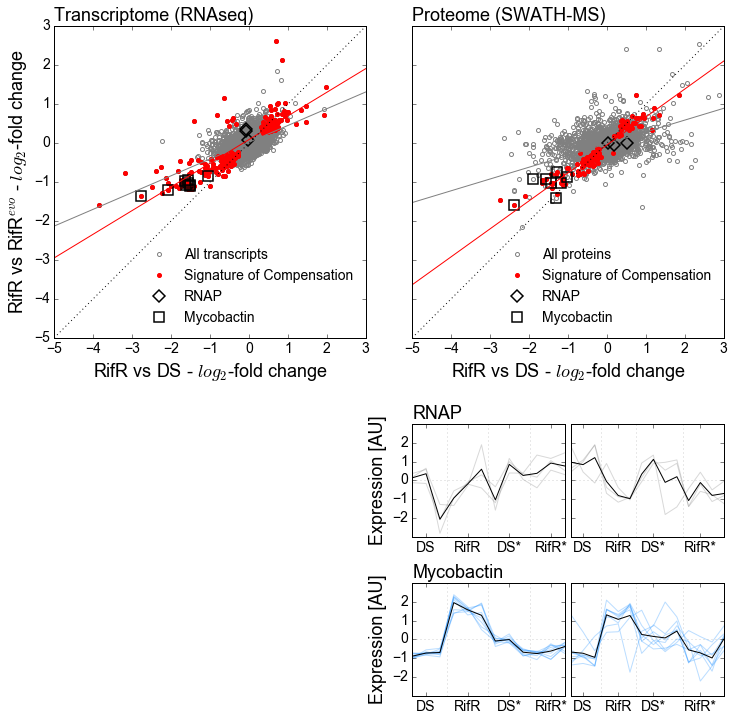

In [32]:
#Define RNAP genes
RNAP_genes = ['Rv0667','Rv0668','Rv3457c']
mycobactin_genes = ['Rv2378c', 'Rv2379c', 'Rv2380c','Rv2381c',
                    'Rv2382c','Rv2383c','Rv2384','Rv2385',
                    'Rv2386c']

RNAP_genes_RNASeq = [np.where(tbx8.genes==x)[0][0] for x in RNAP_genes if x in tbx8.genes]
RNAP_genes_SWATH = [np.where(tbx8p.genes==x)[0][0] for x in RNAP_genes if x in tbx8p.genes]
mycobactin_genes_RNASeq = [np.where(tbx8.genes==x)[0][0] for x in mycobactin_genes if x in tbx8.genes]
mycobactin_genes_SWATH = [np.where(tbx8p.genes==x)[0][0] for x in mycobactin_genes if x in tbx8p.genes]

ordered = [0,1,2]+[11,12,13]+list(np.arange(3,11,1))


plt.figure('Signature_of_compensation',figsize=(12,12))
plt.subplot2grid((17,17),(0,0),rowspan=8,colspan=8)
#Plot the data
plt.plot(transcript_df.RESIST_LFC,
         transcript_df.COMPENSATION_LFC, 
         '.', mec='grey', mfc='none',mew=1, ms=8, label='All transcripts')
plt.plot(transcript_df.RESIST_LFC[(transcript_df.SIG_RESIST=='YES')&(transcript_df.SIG_COMP=='YES')],
         transcript_df.COMPENSATION_LFC[(transcript_df.SIG_RESIST=='YES')&(transcript_df.SIG_COMP=='YES')], 
         '.', mec='red', mfc='red',mew=1., ms=8, label='Signature of Compensation')
plt.plot(transcript_df.RESIST_LFC[transcript_df.index.isin(['Rv0667','Rv0668','Rv3457c'])],
         transcript_df.COMPENSATION_LFC[transcript_df.index.isin(['Rv0667','Rv0668','Rv3457c'])], 
         'D', mec='black', mfc='none',mew=1.5, ms=8, label='RNAP')
plt.plot(transcript_df.RESIST_LFC[transcript_df.index.isin(mycobactin_genes)],
         transcript_df.COMPENSATION_LFC[transcript_df.index.isin(mycobactin_genes)], 
         's', mec='black', mfc='none',mew=1.5, ms=10, label='Mycobactin')

s,i,r,p,e = ss.linregress(
    transcript_df.RESIST_LFC,transcript_df.COMPENSATION_LFC
)

#plot trendlines
resist_slope = result_transcriptome.params['RESIST_LFC']
resist_intercept = result_transcriptome.params['Intercept']
comp_slope = resist_slope+result_transcriptome.params['RESIST_LFC:SIG_COMP[T.YES]']
comp_intercept = resist_intercept+result_transcriptome.params['SIG_COMP[T.YES]']
plt.plot(np.arange(-5,3.1,1),
         np.arange(-5,3.1,1)*s+i,
         '-', color='grey')
plt.plot(np.arange(-5,3.1,1),np.arange(-5,3.1,1)*comp_slope+comp_intercept,'-', color='red')
plt.plot(np.arange(-5,3.1,1),np.arange(-5,3.1,1),'k:')

#Labels and axis limits
plt.title('Transcriptome (RNAseq)', size=label_size, loc='left')
plt.ylim(-5,3)
plt.xlim(-5,3)
plt.ylabel(r'RifR vs RifR$^{evo}$ - $log_2$-fold change', size=label_size)
plt.xlabel(r'RifR vs DS - $log_2$-fold change', size=label_size)
plt.legend(loc=4, frameon=False, fontsize=axis_size)
plt.xticks(size=14)
plt.yticks(size=14)

plt.subplot2grid((17,17),(0,9),rowspan=8,colspan=8)
#plot the data
plt.plot(proteome_df.RESIST_LFC,
         proteome_df.COMPENSATION_LFC, '.', mec='grey', 
         mfc='none',mew=1, ms=8, 
         label='All proteins')
plt.plot(proteome_df.RESIST_LFC[(proteome_df.SIG_RESIST=='YES')&(proteome_df.SIG_COMP=='YES')],
         proteome_df.COMPENSATION_LFC[(proteome_df.SIG_RESIST=='YES')&(proteome_df.SIG_COMP=='YES')], 
         '.', mec='red', mfc='red',mew=1, ms=8, label='Signature of Compensation')
plt.plot(proteome_df.RESIST_LFC[proteome_df.index.isin(['Rv0667','Rv0668','Rv3457c'])],
         proteome_df.COMPENSATION_LFC[proteome_df.index.isin(['Rv0667','Rv0668','Rv3457c'])], 
         'D', mec='black', mfc='none',mew=1.5, ms=8, label='RNAP')
plt.plot(proteome_df.RESIST_LFC[proteome_df.index.isin(mycobactin_genes)],
         proteome_df.COMPENSATION_LFC[proteome_df.index.isin(mycobactin_genes)], 
         's', mec='black', mfc='none',mew=1.5, ms=10, label='Mycobactin')

#plot trendlines
s,i,r,p,e = ss.linregress(
    proteome_df.RESIST_LFC,proteome_df.COMPENSATION_LFC
)
resist_slope = result_proteome.params['RESIST_LFC']
resist_intercept = result_proteome.params['Intercept']
comp_slope = resist_slope+result_proteome.params['RESIST_LFC:SIG_COMP[T.YES]']
comp_intercept = resist_intercept+result_proteome.params['SIG_COMP[T.YES]']
plt.plot(np.arange(-5,3.1,1),
         np.arange(-5,3.1,1)*s+i,
         '-', color='grey')
plt.plot(np.arange(-5,3.1,1),np.arange(-5,3.1,1)*comp_slope+comp_intercept,'r-')
plt.plot(np.arange(-5,3.1,1),np.arange(-5,3.1,1),'k:')

#Labels and axis limits
plt.title('Proteome (SWATH-MS)', size=label_size, loc='left')
plt.ylim(-5,3)
plt.xlim(-5,3)
plt.xlabel(r'RifR vs DS - $log_2$-fold change', size=label_size)
plt.yticks(np.arange(-5,4,1),[])
plt.xticks(size=14)
plt.legend(loc=4, frameon=False, fontsize=axis_size)

plt.subplot2grid((17,17),(10,9),rowspan=3,colspan=4)
data = RNAP_genes_RNASeq
plt.plot(ss.zscore(tbx8.TPM[data].T,axis=0),'-',color='grey',mec='grey',
         mfc='none',mew=1,ms=12,alpha=0.3)
plt.plot(np.mean(ss.zscore(tbx8.TPM[data].T,axis=0),axis=1),'-',color='black',mec='grey',
         mfc='none',mew=1,ms=12,)
plt.xticks(np.arange(1,12,3),['DS','RifR','DS*','RifR*'],size=14)
plt.yticks(np.arange(-2,3,1),size=14)
plt.ylabel('Expression [AU]',size=label_size)
plt.title(f'RNAP',size=18,loc='left')
plt.ylim(-3,3)
plt.vlines([2.5,5.5,8.5],[-3,-3,-3],[3,3,3],linestyles='dotted',colors='lightgrey')
plt.hlines(0,0,11,linestyles='dotted',colors='lightgrey')

plt.subplot2grid((17,17),(14,9),rowspan=3,colspan=4)
data = mycobactin_genes_RNASeq
plt.plot(ss.zscore(tbx8.TPM[data].T,axis=0),'-',color='dodgerblue',
         mec='grey',mfc='none',mew=1,ms=12,alpha=0.3)
plt.plot(np.mean(ss.zscore(tbx8.TPM[data].T,axis=0),axis=1),'-',color='black',
         mec='black',mfc='none',mew=1,lw=1,ms=12)
plt.xticks(np.arange(1,12,3),['DS','RifR','DS*','RifR*'],size=14)
plt.title(f'Mycobactin',size=18,loc='left')
plt.ylim(-3,3)
plt.ylabel('Expression [AU]',size=label_size)
plt.vlines([2.5,5.5,8.5],[-3,-3,-3],[3,3,3],linestyles='dotted',colors='lightgrey')
plt.hlines(0,0,11,linestyles='dotted',colors='lightgrey')
plt.yticks(np.arange(-2,3,1),size=14)

plt.subplot2grid((17,17),(10,13),rowspan=3,colspan=4)
data = RNAP_genes_SWATH
plt.plot(ss.zscore((tbx8p.data[data]/np.sum(tbx8p.data,axis=0)).T[ordered],axis=0),
         '-',color='grey',alpha=0.3)
plt.plot(np.mean(ss.zscore((tbx8p.data[data]/np.sum(tbx8p.data,axis=0)).T[ordered],axis=0),axis=1),
         '-',color='black')
#plt.title(f'SWATH-MS - RNAP',size=18,loc='left')
plt.xticks([1,4,7,11],['DS','RifR','DS*','RifR*'],size=14)
plt.yticks(np.arange(-2,3,1),[])
plt.vlines([2.5,5.5,9.5],[-3,-3,-3,],[3,3,3],linestyles='dotted',colors='lightgrey')
plt.hlines(0,0,13,linestyles='dotted',colors='lightgrey')

plt.ylim(-3,3)

plt.subplot2grid((17,17),(14,13),rowspan=3,colspan=4)
data = mycobactin_genes_SWATH
plt.plot(ss.zscore((tbx8p.data[data]/np.sum(tbx8p.data,axis=0)).T[ordered],axis=0),
         '-',color='dodgerblue',alpha=0.3)
plt.plot(np.mean(ss.zscore((tbx8p.data[data]/np.sum(tbx8p.data,axis=0)).T[ordered],axis=0),axis=1),
         '-',color='black')
#plt.title(f'SWATH-MS - Mycobactin',size=18,loc='left')
plt.xticks([1,4,7,11],['DS','RifR','DS*','RifR*'],size=14)
plt.ylim(-3,3)
plt.yticks(np.arange(-2,3,1),[])
plt.vlines([2.5,5.5,9.5],[-3,-3,-3,],[3,3,3],linestyles='dotted',colors='lightgrey')
plt.hlines(0,0,13,linestyles='dotted',colors='lightgrey')

plt.tight_layout()

# plt.savefig('./reports/figures/1_Compensation_xy_plot.pdf')
# plt.savefig('./reports/figures/1_Compensation_xy_plot.png',dpi=600)

Based on this it is clear that the genes that are differentially expressed between RifR and RifRevo to a great extent re-calibrate aberrant expression. There are two key findings here:
1. the compensatory RpoC mutation corrects 42% of the overall Transcriptional defect and 30% of the global proteomic effect of RpoB Ser450Leu. 
2. compensated genes see 60-70% restoration of their normal expression (the slope of the compensated transcripts is 0.607 with an R2 of 0.74, while the compensated proteins have a slope of 0.718 and an R2 of 0.9).

Next, let's look specifically at the compensated genes.

In [33]:
compensated_proteins = set(proteome_df.index[(proteome_df.SIG_RESIST=='YES')&(proteome_df.SIG_COMP=='YES')])
compensated_transcripts = set(transcript_df.index[(transcript_df.SIG_RESIST=='YES')&(transcript_df.SIG_COMP=='YES')])

print(f'There are {len(compensated_transcripts)} compensated transcripts and {len(compensated_proteins)} compensated proteins. The overlap is {len(compensated_proteins&compensated_transcripts)}')

There are 225 compensated transcripts and 142 compensated proteins. The overlap is 35


There are only 35 genes that are overlapping. Is this aligned with expectation? Let's have a quick look by resampling.

In [34]:
overlap = []
for x in range(10000):
    rna_a = set(sku.resample(tbx8.genes[:-50],replace=False,n_samples=225))
    protein_a = set(sku.resample(tbx8p.genes,replace=False,n_samples=142))
    overlap.append(len(rna_a&protein_a))

In [35]:
ss.describe(overlap)

DescribeResult(nobs=10000, minmax=(0, 20), mean=8.0691, variance=7.394864676467647, skewness=0.24475861345011896, kurtosis=-0.03413066526222375)

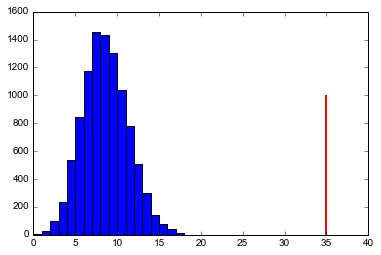

In [36]:
plt.hist(overlap,bins=np.arange(40))
plt.vlines(35,0,1000, colors='red',lw=2)

Clearly our outcome is highly unlikely to have emerged by chance, suggesting that RNA and protein are not independent. Next, let's see what genes are affected.

In [37]:
tbx8.descriptor(list(compensated_proteins&compensated_transcripts))

----------
Top Overlapping genesets
----------
%	Geneset	Description	Genes covered
45.7%	GO:0005886	plasma membrane	['Rv3160c', 'Rv1345', 'Rv3003c', 'Rv3049c', 'Rv1010', 'Rv1922', 'Rv2386c', 'Rv3080c', 'Rv0677c', 'Rv1179c', 'Rv3470c', 'Rv2377c', 'Rv0890c', 'Rv1180', 'Rv1347c', 'Rv0410c']
34.3%	REG:Rv2711_Balazsi2008		['Rv2380c', 'Rv0274', 'Rv1922', 'Rv2386c', 'Rv3080c', 'Rv3001c', 'Rv3720', 'Rv0677c', 'Rv1179c', 'Rv3470c', 'Rv2377c', 'Rv2121c']
31.4%	REG:IdeR_Fe_repressed_Rodriguez2002		['Rv2380c', 'Rv0274', 'Rv1922', 'Rv2386c', 'Rv3001c', 'Rv3720', 'Rv0677c', 'Rv1179c', 'Rv3470c', 'Rv2377c', 'Rv2121c']
28.6%	GO:0005829	cytosol	['Rv3160c', 'Rv1345', 'Rv1348', 'Rv1181', 'Rv3049c', 'Rv2386c', 'Rv0677c', 'Rv1179c', 'Rv0890c', 'Rv1180']
25.7%	GO:0040007	growth	['Rv1345', 'Rv0274', 'Rv1922', 'Rv2386c', 'Rv3080c', 'Rv3720', 'Rv2377c', 'Rv0890c', 'Rv2381c']
20.0%	GO:0005618	cell wall	['Rv1181', 'Rv3049c', 'Rv1010', 'Rv0677c', 'Rv3403c', 'Rv0948c', 'Rv1180']
20.0%	COG:Q	Secondary metabolites b

About a third of these genes belong to the IdeR regulon `REG:Rv2711_Balazsi2008`, `REG:IdeR_Fe_repressed_Rodriguez2002`. Let's have a look at the geneset enrichment for these two, select only genes whose differential expression is specific to RifR.

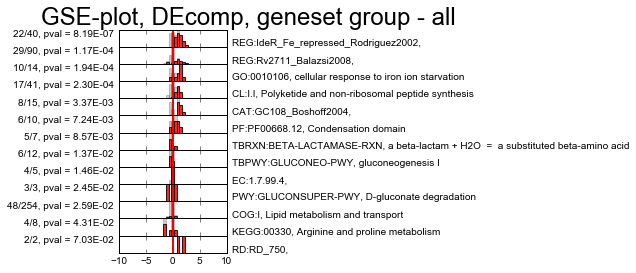

In [38]:
#Perform a geneset enrichment analysis based on the Fisher's exact focused on N0155-N1981 comparison
tbx8.collate_genesets(method='ORA_fisher', dataset='DEcomp',DEtype='DESeq2')
#Plot the top 20 genesets. 
tbx8.GSplot(dataset='DEcomp', DEtype='DESeq2')

In [39]:
a,b = 22,40
c,d = len(np.where(np.in1d(tbx8.knowledge.genes, tbx8.DEcomp_genes[tbx8.DEcomp_significant]))[0]), len(tbx8.knowledge.genes)

print('Odds Ratio = {0:.2f}, p-value = {1:.2e}'.format(*ss.fisher_exact([[a,b],[c-a,d-b]])))

Odds Ratio = 4.27, p-value = 8.19e-07


In [40]:
a,b = 17,41
c,d = len(np.where(np.in1d(tbx8.knowledge.genes, tbx8.DEcomp_genes[tbx8.DEcomp_significant]))[0]), len(tbx8.knowledge.genes)

print('Odds Ratio = {0:.2f}, p-value = {1:.2e}'.format(*ss.fisher_exact([[a,b],[c-a,d-b]])))

Odds Ratio = 3.19, p-value = 2.30e-04


In [41]:
print('Total DE genes: {}'.format(len(tbx8.DEcomp_significant)))
print('More abundant transcripts: {}'.format(len(np.where(tbx8.DEcomp_data[[tbx8.DEcomp_significant],1]>0)[0])))
print('Less abundant transcripts: {}'.format(len(np.where(tbx8.DEcomp_data[[tbx8.DEcomp_significant],1]<0)[0])))

Total DE genes: 536
More abundant transcripts: 247
Less abundant transcripts: 289


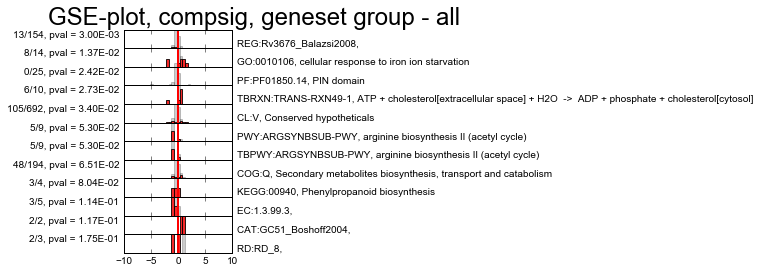

In [42]:
#Perform a geneset enrichment analysis based on the Fisher's exact focused on N0155-N1981 comparison
tbx8p.collate_genesets(method='ORA_fisher', dataset='compsig',DEtype='edgeR')
#Plot the top 20 genesets. 
tbx8p.GSplot(dataset='compsig', DEtype='edgeR')

In [43]:
print('Total DE genes: {}'.format(len(tbx8p.compsig_significant)))
print('More abundant proteins: {}'.format(len(np.where(tbx8p.compsig_data[[tbx8p.compsig_significant],0]>0)[0])))
print('Less abundant proteins: {}'.format(len(np.where(tbx8p.compsig_data[[tbx8p.compsig_significant],0]<0)[0])))

Total DE genes: 536
More abundant proteins: 260
Less abundant proteins: 276


IdeR iron-repressed genes, RNAseq:  4.269253438113949
IdeR iron-repressed genes, proteome:  2.036820540835837
Iron Starvation, RNAseq:  5.452426652042774
Iron Starvation, proteome:  3.1266233766233764
Polyketide, RNAseq:  3.1863908133244756
Polyketide, proteome:  1.3994036324207102


Text(0.5, 0, '$log_2$ fold change')

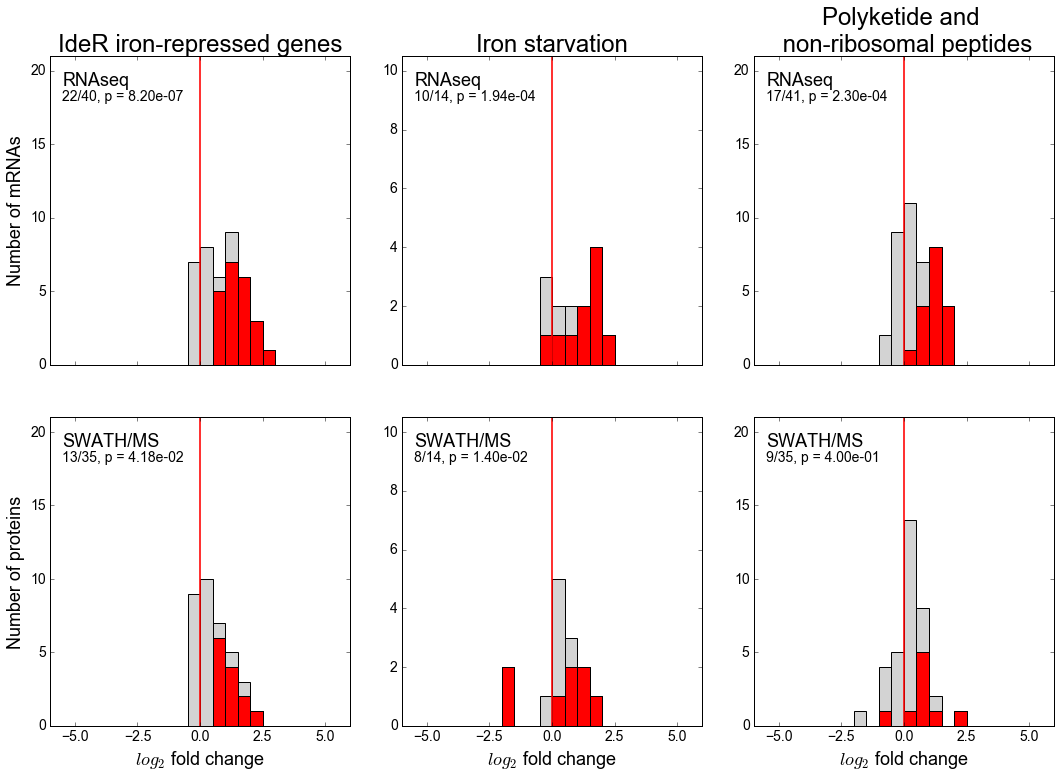

In [44]:
GO_iron = np.array(tbx8.knowledge.genes)[tbx8.knowledge.GO_matrix[:,631]==1]
PolyK = np.array(tbx8.knowledge.genes)[tbx8.knowledge.CL_matrix[:,49]==1]
IdeR_Fe_repressed = np.array(tbx8.knowledge.genes)[tbx8.knowledge.REG_matrix[:,5]==1]

R_I = [np.where(tbx8.DEcomp_genes==x)[0] for x in IdeR_Fe_repressed if x in tbx8.DEcomp_genes]
P_I = [np.where(tbx8p.compsig_genes==x)[0] for x in IdeR_Fe_repressed if x in tbx8p.compsig_genes]
R_Is = np.intersect1d(R_I,tbx8.DEcomp_significant)
P_Is = np.intersect1d(P_I,tbx8p.compsig_significant)

plt.figure('Custom_hist', figsize=(18,12))
plt.subplot2grid((15,23), (0,0), rowspan=7, colspan=7)
plt.title('IdeR iron-repressed genes', size=24)
_o,_p = ss.fisher_exact([[len(R_I), len(R_Is)],[3991-len(R_I), 531-len(R_Is)]])
print('IdeR iron-repressed genes, RNAseq: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(R_Is), len(R_I), _p)
plt.hist(tbx8.DEcomp_data[R_I,1]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8.DEcomp_data[R_Is,1]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,21,colors='red',alpha=0.8,lw=2)
plt.ylim(0,21)
plt.xlim(-6,6)
plt.yticks(np.arange(0,21,5),size=14)
plt.xticks(np.arange(-5,5.1,2.5),[],size=14)
plt.text(-5.5, 19, 'RNAseq', size=18, horizontalalignment='left')
plt.text(-5.5, 18, _text, size=14, horizontalalignment='left')
plt.ylabel(r'Number of mRNAs', size=18)

plt.subplot2grid((15,23), (8,0), rowspan=7, colspan=7)
_o,_p = ss.fisher_exact([[len(P_I), len(P_Is)],
                      [2903-len(P_I), 536-len(P_Is)]])
print('IdeR iron-repressed genes, proteome: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(P_Is), len(P_I), _p)
plt.hist(tbx8p.compsig_data[P_I,0]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8p.compsig_data[P_Is,0]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,21,colors='red',alpha=0.8,lw=2)
plt.ylim(0,21)
plt.xlim(-6,6)
plt.yticks(np.arange(0,21,5),size=14)
plt.xticks(np.arange(-5,5.1,2.5),size=14)
plt.text(-5.5, 19, 'SWATH/MS', size=18, horizontalalignment='left')
plt.text(-5.5, 18, _text, size=14, horizontalalignment='left')
plt.xlabel(r'$log_2$ fold change', size=18)
plt.ylabel(r'Number of proteins', size=18)

R_I = [np.where(tbx8.DEcomp_genes==x)[0] for x in GO_iron if x in tbx8.DEcomp_genes]
P_I = [np.where(tbx8p.compsig_genes==x)[0] for x in GO_iron if x in tbx8p.compsig_genes]
R_Is = np.intersect1d(R_I,tbx8.DEcomp_significant)
P_Is = np.intersect1d(P_I,tbx8p.compsig_significant)

plt.subplot2grid((15,23), (0,8), rowspan=7, colspan=7)
plt.title('Iron starvation', size=24)
_o,_p = ss.fisher_exact([[len(R_I), len(R_Is)],[3991-len(R_I), 531-len(R_Is)]])
print('Iron Starvation, RNAseq: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(R_Is), len(R_I), _p)
plt.hist(tbx8.DEcomp_data[R_I,1]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8.DEcomp_data[R_Is,1]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,42,colors='red',alpha=0.8,lw=2)
plt.ylim(0,10.5)
plt.xlim(-6,6)
plt.yticks(np.arange(0,11,2),size=14)
plt.xticks(np.arange(-5,5.1,2.5),[],size=14)
plt.text(-5.5, 9.5, 'RNAseq', size=18, horizontalalignment='left')
plt.text(-5.5, 9, _text, size=14, horizontalalignment='left')
#plt.ylabel(r'Number of mRNAs', size=18)

plt.subplot2grid((15,23), (8,8), rowspan=7, colspan=7)
_o,_p = ss.fisher_exact([[len(P_I), len(P_Is)],
                      [2903-len(P_I), 536-len(P_Is)]])
print('Iron Starvation, proteome: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(P_Is), len(P_I), _p)
plt.hist(tbx8p.compsig_data[P_I,0]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8p.compsig_data[P_Is,0]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,21,colors='red',alpha=0.8,lw=2)
plt.ylim(0,10.5)
plt.xlim(-6,6)
plt.yticks(np.arange(0,11,2),size=14)
plt.xticks(np.arange(-5,5.1,2.5),size=14)
plt.text(-5.5, 9.5, 'SWATH/MS', size=18, horizontalalignment='left')
plt.text(-5.5, 9, _text, size=14, horizontalalignment='left')
plt.xlabel(r'$log_2$ fold change', size=18)

R_I = [np.where(tbx8.DEcomp_genes==x)[0] for x in PolyK if x in tbx8.DEcomp_genes]
P_I = [np.where(tbx8p.compsig_genes==x)[0] for x in PolyK if x in tbx8p.compsig_genes]
R_Is = np.intersect1d(R_I,tbx8.DEcomp_significant)
P_Is = np.intersect1d(P_I,tbx8p.compsig_significant)

plt.subplot2grid((15,23), (0,16), rowspan=7, colspan=7)
plt.title('Polyketide and \n non-ribosomal peptides', size=24)
_o,_p = ss.fisher_exact([[len(R_I), len(R_Is)],[3991-len(R_I), 531-len(R_Is)]])
print('Polyketide, RNAseq: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(R_Is), len(R_I), _p)
plt.hist(tbx8.DEcomp_data[R_I,1]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8.DEcomp_data[R_Is,1]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,42,colors='red',alpha=0.8,lw=2)
plt.ylim(0,21)
plt.xlim(-6,6)
plt.yticks(np.arange(0,21,5),size=14)
plt.xticks(np.arange(-5,5.1,2.5),[],size=14)
plt.text(-5.5, 19, 'RNAseq', size=18, horizontalalignment='left')
plt.text(-5.5, 18, _text, size=14, horizontalalignment='left')
#plt.ylabel(r'Number of mRNAs', size=18)

plt.subplot2grid((15,23), (8,16), rowspan=7, colspan=7)
_o,_p = ss.fisher_exact([[len(P_I), len(P_Is)],
                      [2903-len(P_I), 536-len(P_Is)]])
print('Polyketide, proteome: ',1/_o)
_text = '%s/%s, p = %.2e' %(len(P_Is), len(P_I), _p)
plt.hist(tbx8p.compsig_data[P_I,0]*1., bins=np.arange(-5,5.5,.5), color='lightgrey', edgecolor='black')
plt.hist(tbx8p.compsig_data[P_Is,0]*1., bins=np.arange(-5,5.5,.5), color='red', edgecolor='black')
plt.vlines(0,0,21,colors='red',alpha=0.8,lw=2)
plt.ylim(0,21)
plt.xlim(-6,6)
plt.yticks(np.arange(0,21,5),size=14)
plt.xticks(np.arange(-5,5.1,2.5),size=14)
plt.text(-5.5, 19, 'SWATH/MS', size=18, horizontalalignment='left')
plt.text(-5.5, 18, _text, size=14, horizontalalignment='left')
plt.xlabel(r'$log_2$ fold change', size=18)


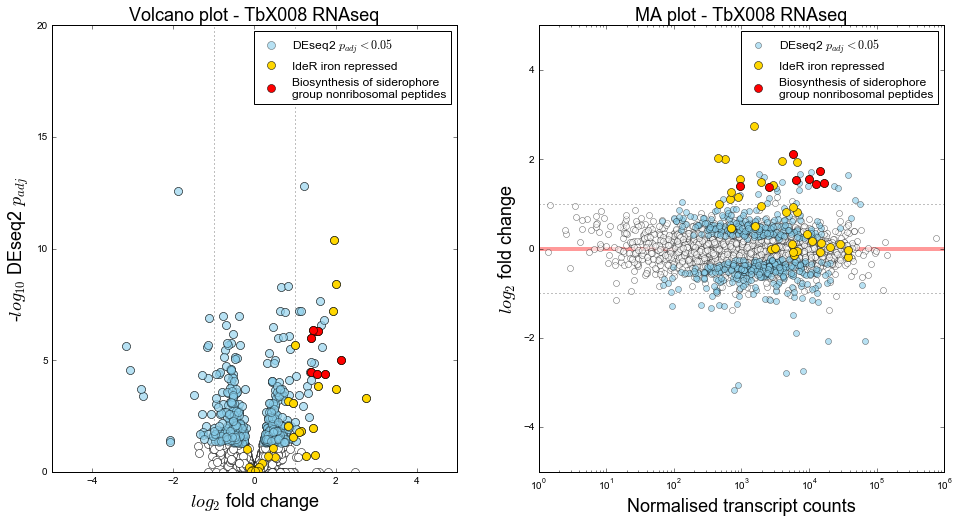

In [45]:
pathway = 'mtu01053'
pathway_name = 'Biosynthesis of siderophore\ngroup nonribosomal peptides'
pathway_data = rq.get('http://rest.kegg.jp/get/'+pathway)
pathway_genes = []
for line in pathway_data.text.strip().split('\n'):
    split = line.split()
    if 'Rv' in split[0]: 
        pathway_genes.append(split[0])

ideR_name = 'IdeR iron repressed'
ideR_genes = ['Rv0116c','Rv0282','Rv0283','Rv0284','Rv0285','Rv0286','Rv0287',
                'Rv0288','Rv0289','Rv0290','Rv0291','Rv0292','Rv0766c','Rv0450c',
                'Rv0451c','Rv0587','Rv1343c','Rv1344','Rv1345','Rv1346','Rv1347c',
                'Rv1348','Rv1349','Rv1519','Rv2122c','Rv2123','Rv2377c','Rv2378c',
                'Rv2379c','Rv2380c','Rv2381c','Rv2382c','Rv2383c','Rv2384','Rv2385',
                'Rv2386c','Rv3402c','Rv3403c','Rv3839','Rv3840']

pathway_index = [np.where(tbx8.DESeq_genes==x)[0][0] for x in pathway_genes]
ideR_index = [np.where(tbx8.DESeq_genes==x)[0][0] for x in ideR_genes]

plt.figure('volcano', figsize=(16,8), facecolor='w', edgecolor='w')
plt.subplot(121)
plt.plot(tbx8.DEcomp_data[:,1], -np.log10(tbx8.DEcomp_data[:,5]), 'wo', ms=8)
plt.plot(tbx8.DEcomp_data[:,1][tbx8.DEcomp_significant], -np.log10(tbx8.DEcomp_data[:,5][tbx8.DEcomp_significant]), 
         'o', label=r'DEseq2 $p_{adj}<0.05$', ms=8, mfc='skyblue',alpha=0.6)  
plt.plot(tbx8.DEcomp_data[:,1][ideR_index], -np.log10(tbx8.DEcomp_data[:,5][ideR_index]), 
         'o', label=ideR_name, mfc='gold', ms=8)
plt.plot(tbx8.DEcomp_data[:,1][pathway_index], -np.log10(tbx8.DEcomp_data[:,5][pathway_index]), 
         'ro', label=pathway_name, ms=8)

plt.xlabel(r'$log_2$ fold change', fontsize=18)
plt.ylabel(r'-$log_{10}$ DEseq2 $p_{adj}$', fontsize=18) 
plt.title('Volcano plot - TbX008 RNAseq', fontsize=18)
plt.xlim(-5,5)
plt.vlines(-1,0,20, color='grey', linestyles='dotted')
plt.vlines(1, 0, 20, color='grey', linestyles='dotted')
plt.legend()

plt.subplot(122)
plt.plot(tbx8.DEcomp_data[tbx8.DEcomp_nonsignificant][:,0],tbx8.DEcomp_data[tbx8.DEcomp_nonsignificant][:,1], 
         'ko', markerfacecolor='white', alpha=0.6)
plt.plot(tbx8.DEcomp_data[tbx8.DEcomp_significant][:,0],tbx8.DEcomp_data[tbx8.DEcomp_significant][:,1], 
         'ko', label=r'DEseq2 $p_{adj}<0.05$', markerfacecolor='skyblue', alpha=0.6)
plt.plot(tbx8.DEcomp_data[ideR_index][:,0], tbx8.DEcomp_data[ideR_index][:,1], 'o', 
         label=ideR_name, ms=8, mfc='gold')
plt.plot(tbx8.DEcomp_data[pathway_index][:,0], tbx8.DEcomp_data[pathway_index][:,1], 'ro', 
         label=pathway_name, ms=8)
plt.xscale('log')
plt.xlim(1,1000000)
plt.ylim(-5, 5)
plt.hlines(0,0.01, max(tbx8.DEcomp_data[:,0]), color='red', linewidth=4, alpha=0.4)
plt.hlines(-1,0.01, max(tbx8.DEcomp_data[:,0]), color='grey', linestyles='dotted')
plt.hlines(1,0.01, max(tbx8.DEcomp_data[:,0]), color='grey', linestyles='dotted')
plt.xlabel('Normalised transcript counts', fontsize=18)
plt.ylabel(r'$log_2$ fold change', fontsize=18)
plt.title('MA plot - TbX008 RNAseq', fontsize=18)
plt.legend()
#plt.suptitle('DESeq2 Differential Expression analysis\nTbX007', size=24)
#plt.savefig('../../../reports/figures/1_TbX008_rsqvol_compsig.pdf')
#plt.savefig('../../../reports/figures/1_TbX008_rsqvol_compsig.png', dpi=600)

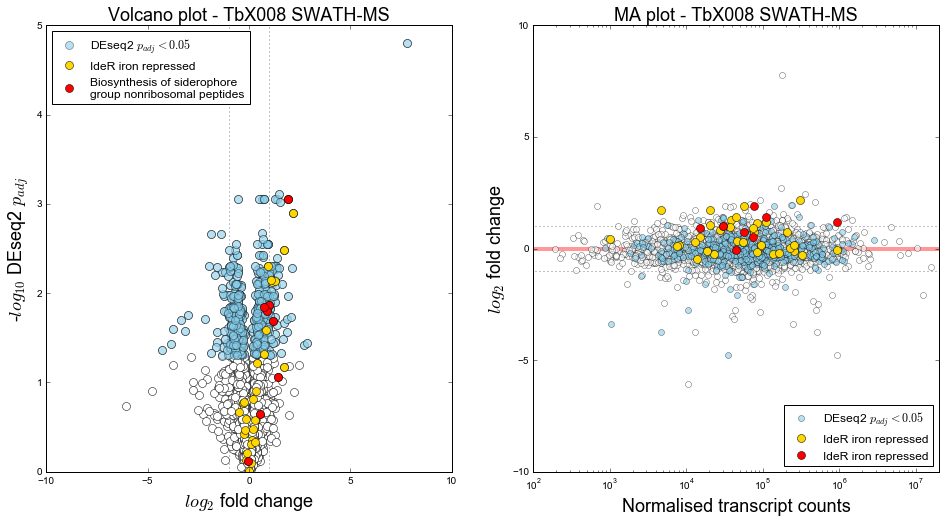

In [46]:
pathway = 'mtu01053'
pathway_name = 'Biosynthesis of siderophore\ngroup nonribosomal peptides'
pathway_data = rq.get('http://rest.kegg.jp/get/'+pathway)
pathway_genes = []
for line in pathway_data.text.strip().split('\n'):
    split = line.split()
    if 'Rv' in split[0]: 
        pathway_genes.append(split[0])

ideR_name = 'IdeR iron repressed'
ideR_genes = ['Rv0116c','Rv0282','Rv0283','Rv0284','Rv0285','Rv0286','Rv0287',
                'Rv0288','Rv0289','Rv0290','Rv0291','Rv0292','Rv0766c','Rv0450c',
                'Rv0451c','Rv0587','Rv1343c','Rv1344','Rv1345','Rv1346','Rv1347c',
                'Rv1348','Rv1349','Rv1519','Rv2122c','Rv2123','Rv2377c','Rv2378c',
                'Rv2379c','Rv2380c','Rv2381c','Rv2382c','Rv2383c','Rv2384','Rv2385',
                'Rv2386c','Rv3402c','Rv3403c','Rv3839','Rv3840']

pathway_index = [np.where(tbx8p.compsig_genes==x)[0][0] for x in pathway_genes if x in tbx8p.compsig_genes]
ideR_index = [np.where(tbx8p.compsig_genes==x)[0][0] for x in ideR_genes if x in tbx8p.compsig_genes]

plt.figure('volcano', figsize=(16,8), facecolor='w', edgecolor='w')
plt.subplot(121)
plt.plot(tbx8p.compsig_data[:,0], -np.log10(tbx8p.compsig_data[:,5]), 'wo', ms=8)
plt.plot(tbx8p.compsig_data[:,0][tbx8p.compsig_significant], -np.log10(tbx8p.compsig_data[:,5][tbx8p.compsig_significant]), 
         'o', label=r'DEseq2 $p_{adj}<0.05$', ms=8, mfc='skyblue',alpha=0.6)  
plt.plot(tbx8p.compsig_data[:,0][ideR_index], -np.log10(tbx8p.compsig_data[:,5][ideR_index]), 
         'o', label=ideR_name, mfc='gold', ms=8)
plt.plot(tbx8p.compsig_data[:,0][pathway_index], -np.log10(tbx8p.compsig_data[:,5][pathway_index]), 
         'ro', label=pathway_name, ms=8)

plt.xlabel(r'$log_2$ fold change', fontsize=18)
plt.ylabel(r'-$log_{10}$ DEseq2 $p_{adj}$', fontsize=18) 
plt.title('Volcano plot - TbX008 SWATH-MS', fontsize=18)
plt.xlim(-10,10)
plt.vlines(-1,0,5, color='grey', linestyles='dotted')
plt.vlines(1, 0, 5, color='grey', linestyles='dotted')
plt.legend(loc=2)

plt.subplot(122)
_nonsigs = np.array(list(set(tbx8p.genes)&set(tbx8p.compsig_genes[tbx8p.compsig_nonsignificant])-set(['Rv2090'])))
_sigs = np.array(list(set(tbx8p.genes)&set(tbx8p.compsig_genes[tbx8p.compsig_significant])))
plt.plot(np.mean(tbx8p.data[np.where(np.in1d(tbx8p.genes,_nonsigs))],axis=1),
         tbx8p.compsig_data[np.where(np.in1d(tbx8p.compsig_genes[tbx8p.compsig_nonsignificant],_nonsigs,))][:,0], 
         'ko', markerfacecolor='white', alpha=0.6)
plt.plot(np.mean(tbx8p.data[np.where(np.in1d(tbx8p.genes,_sigs))],axis=1),
         tbx8p.compsig_data[np.where(np.in1d(tbx8p.compsig_genes[tbx8p.compsig_significant],_sigs,))][:,0],
         'ko', label=r'DEseq2 $p_{adj}<0.05$', markerfacecolor='skyblue', alpha=0.6)
plt.plot(np.mean(tbx8p.data[np.where(np.in1d(tbx8p.genes,tbx8p.compsig_genes[ideR_index]))],axis=1),
         tbx8p.compsig_data[ideR_index][:,0], 'o', 
         label=ideR_name, ms=8, mfc='gold')
plt.plot(np.mean(tbx8p.data[np.where(np.in1d(tbx8p.genes,tbx8p.compsig_genes[pathway_index]))],axis=1),
         tbx8p.compsig_data[pathway_index][:,0], 'o', 
         label=ideR_name, ms=8, mfc='red')
plt.xscale('log')
plt.xlim(100,2e7)
plt.ylim(-10, 10)
plt.hlines(0,0.01, max(tbx8p.data.flatten()), color='red', linewidth=4, alpha=0.4)
plt.hlines(-1,0.01, max(tbx8p.data.flatten()), color='grey', linestyles='dotted')
plt.hlines(1,0.01, max(tbx8p.data.flatten()), color='grey', linestyles='dotted')
plt.xlabel('Normalised transcript counts', fontsize=18)
plt.ylabel(r'$log_2$ fold change', fontsize=18)
plt.title('MA plot - TbX008 SWATH-MS', fontsize=18)
plt.legend(loc=4)

## Impact of Mycobactin on bacterial growth

Next, we tested the possiblity that hemin could revert the impact of RpoB Ser450Leu on the growth of N0155.

In [47]:
GCH_df = pd.read_csv('../Growth_Curves/EVOLUTION_SET_GROWTH_CURVES_HEMIN.csv') #hemin TbX008 data
GCH_df = GCH_df[GCH_df.OD600>0.09] #trim the data for low OD600 reads
GCH_df = GCH_df[GCH_df.OD600<1.6] #trim the data for high OD600 reads
GCH_df['log2OD'] = np.log2(GCH_df.OD600)

In [48]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*HEMIN*STRAIN', 
                                data=GCH_df, 
                                groups=GCH_df.SAMPLE_ID)
result = model.fit()
print(result.summary())

                    Mixed Linear Model Regression Results
Model:                    MixedLM         Dependent Variable:         log2OD  
No. Observations:         84              Method:                     REML    
No. Groups:               22              Scale:                      0.0139  
Min. group size:          3               Likelihood:                 -18.5250
Max. group size:          5               Converged:                  Yes     
Mean group size:          3.8                                                 
------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------
Intercept                          -8.492    0.479 -17.725 0.000 -9.431 -7.553
HEMIN[T.None]                       0.620    0.597   1.039 0.299 -0.550  1.790
STRAIN[T.N1981]                     0.155    0.688   0.225 0.822 -1.194  

There is no interaction between growth rate and Hemin for the wild type (Coeff -0.002, p=0.128), there is an interaction between growth rate and genotype (rpoB is costly, Coeff -0.008, p=0.000) and there is no interaction between genotype and growth in Hemin (Coeff -0.001, p=0.737).

Just for the sake of argument, I'll repeat each of these separately, first comparing N0155 vs N1981 in different Hemin levels.

In [49]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*STRAIN', 
                                data=GCH_df[GCH_df.HEMIN=='None'], 
                                groups=GCH_df.SAMPLE_ID[GCH_df.HEMIN=='None'])
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                MixedLM    Dependent Variable:    log2OD  
No. Observations:     54         Method:                REML    
No. Groups:           14         Scale:                 0.0179  
Min. group size:      3          Likelihood:            -14.8424
Max. group size:      5          Converged:             Yes     
Mean group size:      3.9                                       
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -7.868    0.379 -20.776 0.000 -8.610 -7.126
STRAIN[T.N1981]       0.227    0.547   0.414 0.679 -0.845  1.298
TIME                  0.041    0.001  45.731 0.000  0.039  0.043
TIME:STRAIN[T.N1981] -0.008    0.001  -6.180 0.000 -0.011 -0.006
Group Var             0.852    3.004                            



In [50]:
print('Relative fitness of the rpoB mutant in N0155 without Hemin: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:STRAIN[T.N1981]'])/result.params['TIME'])*100))

Relative fitness of the rpoB mutant in N0155 without Hemin: 79.8%


In [51]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*STRAIN', 
                                data=GCH_df[GCH_df.HEMIN!='None'], 
                                groups=GCH_df.SAMPLE_ID[GCH_df.HEMIN!='None'])
result = model.fit()
print(result.summary())

             Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    log2OD 
No. Observations:      30         Method:                REML   
No. Groups:            8          Scale:                 0.0061 
Min. group size:       3          Likelihood:            -0.3162
Max. group size:       5          Converged:             Yes    
Mean group size:       3.8                                      
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept            -8.495    0.410 -20.702 0.000 -9.300 -7.691
STRAIN[T.N1981]       0.154    0.586   0.262 0.793 -0.995  1.302
TIME                  0.043    0.001  57.875 0.000  0.042  0.045
TIME:STRAIN[T.N1981] -0.008    0.001  -6.824 0.000 -0.010 -0.005
Group Var             0.608    5.124                            



In [52]:
print('Relative fitness of the rpoB mutant in N0155 with Hemin: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:STRAIN[T.N1981]'])/result.params['TIME'])*100))

Relative fitness of the rpoB mutant in N0155 with Hemin: 82.4%


So the cost of rpoB is not affected by the availability of iron. Let's turn it around to see what the impact of hemin on the growth of individual strains is:

In [53]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*HEMIN', 
                                data=GCH_df[GCH_df.STRAIN=='N0155'], 
                                groups=GCH_df.SAMPLE_ID[GCH_df.STRAIN=='N0155'])
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    log2OD 
No. Observations:    45         Method:                REML   
No. Groups:          11         Scale:                 0.0133 
Min. group size:     4          Likelihood:            -8.4546
Max. group size:     5          Converged:             Yes    
Mean group size:     4.1                                      
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -8.494    0.552 -15.394 0.000 -9.576 -7.413
HEMIN[T.None]       0.616    0.689   0.894 0.371 -0.734  1.966
TIME                0.043    0.001  39.376 0.000  0.041  0.045
TIME:HEMIN[T.None] -0.002    0.001  -1.538 0.124 -0.005  0.001
Group Var           1.077    5.010                            



In [54]:
print('Relative growth rate in absence of external Hemin: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:HEMIN[T.None]'])/result.params['TIME'])*100))

Relative growth rate in absence of external Hemin: 95.2%


In [55]:
model = sm.MixedLM.from_formula('log2OD ~ TIME*HEMIN', 
                                data=GCH_df[GCH_df.STRAIN=='N1981'], 
                                groups=GCH_df.SAMPLE_ID[GCH_df.STRAIN=='N1981'])
result = model.fit()
print(result.summary())

            Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    log2OD 
No. Observations:    39         Method:                REML   
No. Groups:          11         Scale:                 0.0146 
Min. group size:     3          Likelihood:            -9.2797
Max. group size:     5          Converged:             Yes    
Mean group size:     3.5                                      
--------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------------
Intercept          -8.328    0.413 -20.166 0.000 -9.138 -7.519
HEMIN[T.None]       0.691    0.514   1.344 0.179 -0.317  1.699
TIME                0.035    0.001  27.867 0.000  0.033  0.038
TIME:HEMIN[T.None] -0.003    0.002  -1.772 0.076 -0.006  0.000
Group Var           0.465    2.129                            



In [56]:
print('Relative growth rate in absence of external Hemin: {0:0=.1f}%'.format(((result.params['TIME']+result.params['TIME:HEMIN[T.None]'])/result.params['TIME'])*100))

Relative growth rate in absence of external Hemin: 92.2%


Overall it seems that the supplementation of 10uM Hemin to our growth medium may have a very small positive effect on the growth rate, however our study was not powerful enough to detect a significant difference. Nonetheless, we can conclude that the addition of hemin to the growth medium does not alleviate the cost of the *rpoB* mutation, suggesting that the upregulation of the mycobactin biosynthesis cluster is not driven by an increased need for iron, but rather by a different mechanism. 

## Mycobactin biosynthesis
Next, we did mycobactin determiation for N1981 and N0155

(0, 1.05)

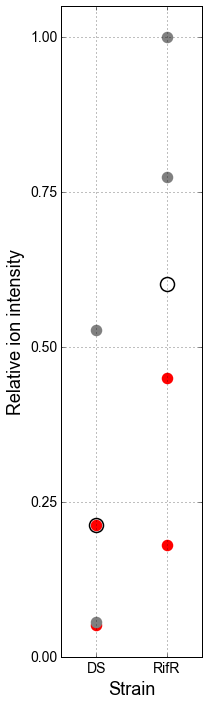

In [57]:
L1981 = np.array([16,40,69,89])/89
L0155 = np.array([4.5,19,5,47])/89

plt.figure(figsize=(3,10))
plt.plot([1,]*2, L1981[:2], 'o', mec='red', mew=1.5, mfc='red', ms=10)
plt.plot([0,]*2, L0155[:2], 'o', mec='red', mew=1.5, mfc='red', ms=10)
plt.plot([1,]*2, L1981[2:4], 'o', mec='grey', mew=1.5, mfc='grey', ms=10)
plt.plot([0,]*2, L0155[2:4], 'o', mec='grey', mew=1.5, mfc='grey', ms=10)
plt.plot([0,1],[np.mean(L0155), np.mean(L1981)], 
         'o', mec='black', mfc='none', mew=1.5, ms=14)
plt.xlim(-.5,1.5)
plt.xticks([0,1],['DS','RifR'], size=axis_size)
plt.xlabel('Strain', size=title_size)
plt.yticks(np.arange(0,1.2,.25), size=axis_size)
plt.ylabel('Relative ion intensity', size=title_size)
plt.grid()
plt.tight_layout()

plt.ylim(0,1.05)


While the mycobactin overexpression might not signal an altered iron metabolism, it is possible the the mere overexpression of the cluster carries a cost. This could provide a very interesting avenue for us to pursue.  

We used previously published expression modules to refine the picture of expression dysregulation imparted by the RpoB mutation.

To better understand the key players mediating differential expression with a particular focus on iron-dependent gene-regulation, I decided to use the previously published expression module definition that combined several strands of data in the generation of the resulting structure, namely:
1. Known regulation based on gene knockout
2. CHiP seq data
3. Co-expression

Data source: Peterson et al., 2014 Nucl Acids Res

In [59]:
#get gene identifiers of interest
with open('./H37Rv_extra_knowledge.txt') as _f:
    _input = _f.read()
    
MTB_genesets = pd.DataFrame([x.split('\t') for x in _input.strip().split('\n')[1:]],
                            columns=['GENE', 'CATEGORY', 'CATEGORY_ID'],)

ider_induced = list(MTB_genesets[(MTB_genesets.CATEGORY_ID=='REG:IdeR_Fe_induced_Rodriguez2002')].GENE)
ider_repressed = list(MTB_genesets[(MTB_genesets.CATEGORY_ID=='REG:IdeR_Fe_repressed_Rodriguez2002')].GENE)
ider = ider_induced+ider_repressed

fe_induced = list(MTB_genesets[(MTB_genesets.CATEGORY_ID=='REG:Fe_induced_Rodriguez2002')].GENE)
fe_repressed = list(MTB_genesets[(MTB_genesets.CATEGORY_ID=='REG:Fe_repressed_Rodriguez2002')].GENE)
fe = fe_induced+fe_repressed

#get module data again
modules = pd.read_table('./Peterson_module_genes.tsv',) 
modules_TF = pd.read_csv('./Peterson_module_TFs.csv',) 

In [64]:
#Generate a new graph
G = nx.Graph()

G.add_edges_from(((x,y) for (x,y) in zip(modules.Gene, modules.Module_ID) if type(x) is str))
G.add_edges_from(((x,y) for (x,y) in zip(modules_TF.TF, modules_TF.Module_ID) if type(x) is str))

ider_modules = []
for x in ider:
    for y in nx.neighbors(G,x):
        if y not in ider_modules: ider_modules.append(y)
            
fe_modules = []
for x in fe:
    for y in nx.neighbors(G,x):
        if y not in fe_modules: fe_modules.append(y)
            
G2_frozen = nx.subgraph(G, ider+fe+ider_modules+fe_modules)

G2 = G2_frozen.copy()

for (node,degree) in G2_frozen.degree(ider_modules):
    if degree>2 and node!='Module_374': G2.add_edge('IdeR',node)

with open('./GRAPH_ANALYSIS_node_positions.json', 'r') as handle:
    posG2 = json.load(handle)

[]

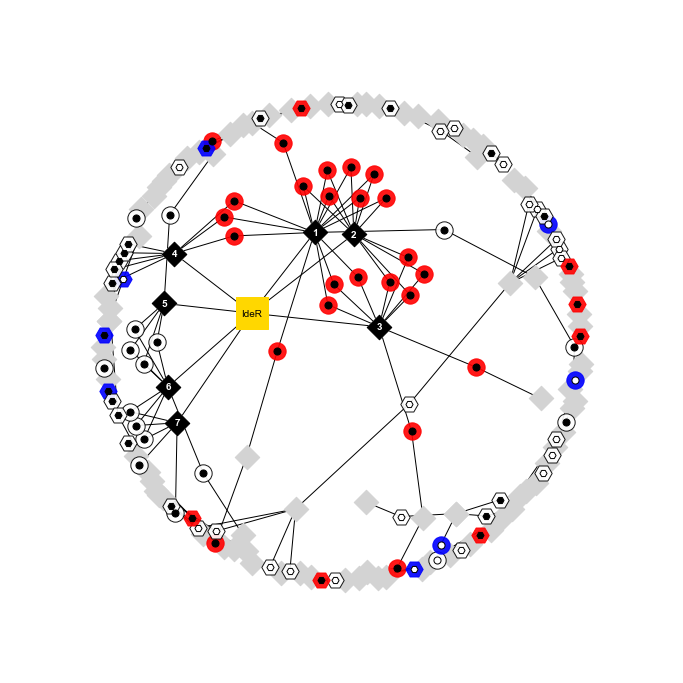

In [68]:
colours = {-1: ['red','red'], 1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,12) )

ax = plt.subplot(111)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    if gene in tbx8.comp_genes[tbx8.comp_significant]: 
        colour_it = np.sign(tbx8.comp_data[np.where(tbx8.comp_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
    a.set_edgecolor(colours.get(colour_it)[1])
    
for gene in fe:
    colour_it = 0
    if gene in tbx8.comp_genes[tbx8.comp_significant]: 
        colour_it = np.sign(tbx8.comp_data[np.where(tbx8.comp_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color=('white'), font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

#plt.savefig('../reports/figures/3_IdeR_network_RNA.pdf')
#plt.savefig('../reports/figures/3_IdeR_network_RNA.png',dpi=600)

[]

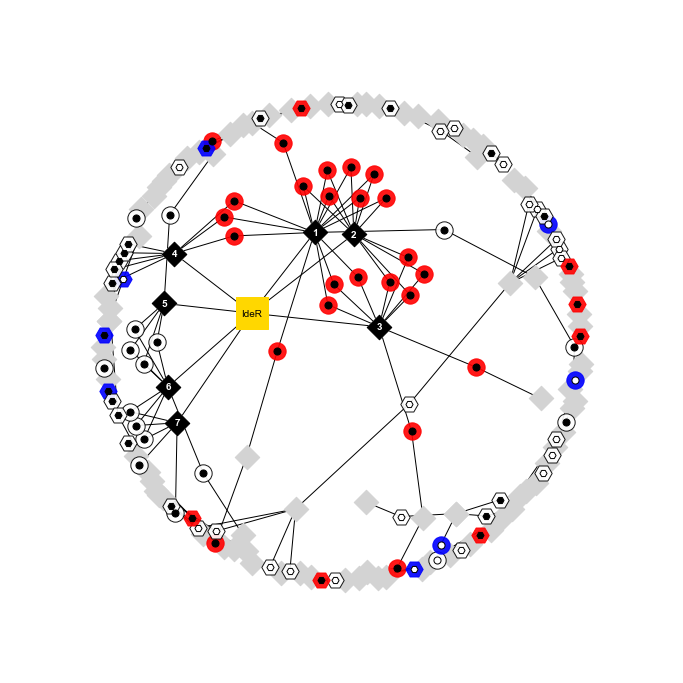

In [68]:
colours = {-1: ['red','red'], 1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,12) )

ax = plt.subplot(111)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    if gene in tbx8.comp_genes[tbx8.comp_significant]: 
        colour_it = np.sign(tbx8.comp_data[np.where(tbx8.comp_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
    a.set_edgecolor(colours.get(colour_it)[1])
    
for gene in fe:
    colour_it = 0
    if gene in tbx8.comp_genes[tbx8.comp_significant]: 
        colour_it = np.sign(tbx8.comp_data[np.where(tbx8.comp_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color=('white'), font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

#plt.savefig('../reports/figures/3_IdeR_network_RNA.pdf')
#plt.savefig('../reports/figures/3_IdeR_network_RNA.png',dpi=600)

What proportion of the genes included in each of these modules is IdeR supposed to be regulating?

In [83]:
ider_module_covered = []

for key in figure_labels.keys():
    module = key
    for gene in G2.neighbors(module):
        if gene in ider_repressed and gene not in ider_module_covered: 
            ider_module_covered.append(gene)
    
    print(key, '  --  ',figure_labels[key])
    print('Proportion of module regulated by IdeR:',len([x for x in G2.neighbors(module)])/len([x for x in G.neighbors(module)]))
    print('Genes in module:',len([x for x in G.neighbors(module)]),)
    print('Genes not regulated by IdeR:',-len([x for x in G2.neighbors(module)])+len([x for x in G.neighbors(module)]),'\n')
    
print('{0:0=.1f}% of IdeR-repressed genes covered by selected modules.'.format(len(ider_module_covered)/len(ider_repressed)*100))

Module_502   --   1
Proportion of module regulated by IdeR: 0.85
Genes in module: 20
Genes not regulated by IdeR: 3 

Module_525   --   2
Proportion of module regulated by IdeR: 0.8
Genes in module: 15
Genes not regulated by IdeR: 3 

Module_267   --   3
Proportion of module regulated by IdeR: 0.625
Genes in module: 16
Genes not regulated by IdeR: 6 

Module_086   --   6
Proportion of module regulated by IdeR: 0.47368421052631576
Genes in module: 19
Genes not regulated by IdeR: 10 

Module_231   --   5
Proportion of module regulated by IdeR: 0.375
Genes in module: 16
Genes not regulated by IdeR: 10 

Module_295   --   7
Proportion of module regulated by IdeR: 0.42857142857142855
Genes in module: 14
Genes not regulated by IdeR: 8 

Module_446   --   4
Proportion of module regulated by IdeR: 0.75
Genes in module: 12
Genes not regulated by IdeR: 3 

82.5% of IdeR-repressed genes covered by selected modules.


So modules with a large proportion of IdeR genes are DE in the signature of compensation. The next question is, how many of these genes are DE between the WT and rpoB mutant.

[]

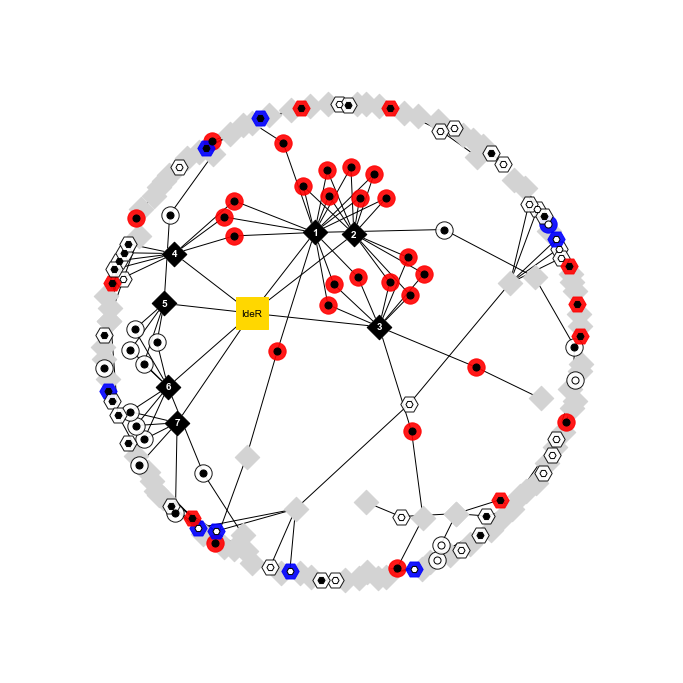

In [88]:
colours = {-1: ['red','red'], 1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,12) )

ax = plt.subplot(111)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    if gene in tbx8.DESeq_genes[tbx8.DESeq_significant]: 
        colour_it = np.sign(tbx8.DESeq_data[np.where(tbx8.DESeq_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
    a.set_edgecolor(colours.get(colour_it)[1])
    
for gene in fe:
    colour_it = 0
    if gene in tbx8.DESeq_genes[tbx8.DESeq_significant]: 
        colour_it = np.sign(tbx8.DESeq_data[np.where(tbx8.DESeq_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color='white', font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

There is a greater involvement. But the finding is effectively the same.

Let's look at the proteome now...

[]

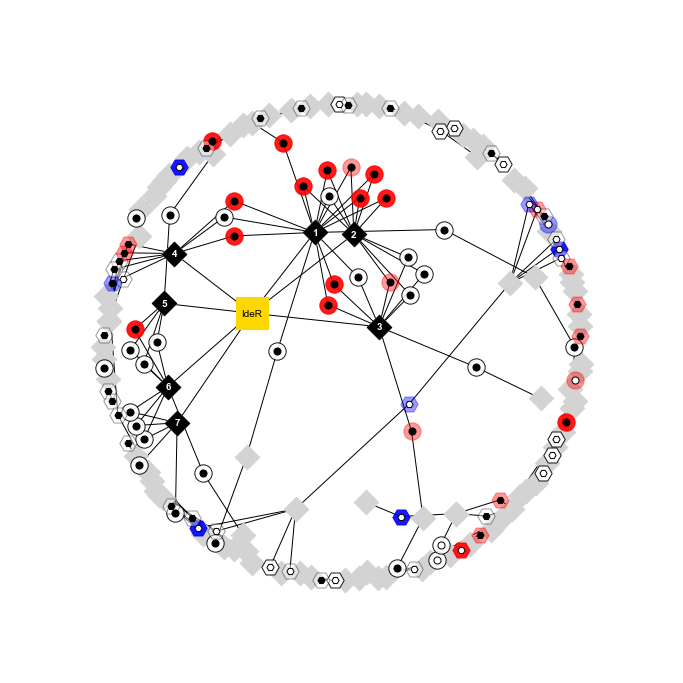

In [96]:
colours = {1: ['red','red'], -1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,12) )

ax = plt.subplot(111)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    _alpha=0.9
    if gene in tbx8p.compsig_genes:
        if tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]<0.05: 
            colour_it = np.sign(tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][0])
        if tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]>=0.05 and tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]<0.1: 
            colour_it = np.sign(tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][0])
            _alpha=0.4
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=_alpha)
    a.set_edgecolor(colours.get(colour_it)[1])

    
for gene in fe:
    colour_it = 0
    if gene in tbx8p.compsig_genes:
        if tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]<0.05: 
            colour_it = np.sign(tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][0])
        if tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]>=0.05 and tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][5]<0.1: 
            colour_it = np.sign(tbx8p.compsig_data[np.where(tbx8p.compsig_genes==gene)[0][0]][0])
            _alpha=0.4
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=_alpha,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color=('white'), font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

#plt.savefig('../reports/figures/3_IdeR_network_RNA.pdf')
#plt.savefig('../reports/figures/3_IdeR_network_RNA.png',dpi=600)

Clearly, not all of the IdeR-dependnt expression modules are dysregulated. Only modules 1,2,3 and half of 4 are dysregulated. The others, many including fe-responsive genes [hexagons] are not consistently affected. This finding combined with the fact that hemin does not alleviate the cost of RpoB Ser450Leu raises the possibility that dysregulation itself is costly. The next step is therefore to test the hypothesis that the pheontype of expression dysregulation is generalizable for rpoB S450L mutants across different genetic backgrounds and lays at the heart of the cost of resistance.

## Generalisability of the IdeR signature.

We used a panel of 5 mutant:wild type pairs to address the question. The experiment was named TbX011 and it covered a GENETIC DIVERSITY SET of strains.

First we performed a growth curve study.

In [98]:
#model = sm.MixedLM.from_formula("log2OD ~ TIME*C(STRAIN, Treatment(reference='N0155'))",
model = sm.MixedLM.from_formula("log2OD ~ TIME*BACKGROUND/RESISTANT", 
                                data=GC_df, 
                                groups=GC_df.SAMPLE)
result = model.fit()
print(result.summary())

                   Mixed Linear Model Regression Results
Model:                    MixedLM        Dependent Variable:        log2OD  
No. Observations:         103            Method:                    REML    
No. Groups:               33             Scale:                     0.0094  
Min. group size:          2              Likelihood:                -43.9069
Max. group size:          5              Converged:                 Yes     
Mean group size:          3.1                                               
----------------------------------------------------------------------------
                                 Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                        -6.950    0.366 -18.965 0.000 -7.669 -6.232
BACKGROUND[T.N0072]              -0.099    0.491  -0.202 0.840 -1.061  0.863
BACKGROUND[T.N0145]               0.062    0.535   0.115 0.908 -0.988  1.111
BACKGROUND[T.N0155]

In [99]:
result_names = {'N0052':{'slope': 'TIME', 'R': 'TIME:BACKGROUND[N0052]:RESISTANT'}}
for strain in ['N0072', 'N0145', 'N0155','N0157']:
    result_names[strain] = {'slope': 'TIME:BACKGROUND[T.{}]'.format(strain), 
                            'R': 'TIME:BACKGROUND[{}]:RESISTANT'.format(strain) }
    
result_names

{'N0052': {'slope': 'TIME', 'R': 'TIME:BACKGROUND[N0052]:RESISTANT'},
 'N0072': {'slope': 'TIME:BACKGROUND[T.N0072]',
  'R': 'TIME:BACKGROUND[N0072]:RESISTANT'},
 'N0145': {'slope': 'TIME:BACKGROUND[T.N0145]',
  'R': 'TIME:BACKGROUND[N0145]:RESISTANT'},
 'N0155': {'slope': 'TIME:BACKGROUND[T.N0155]',
  'R': 'TIME:BACKGROUND[N0155]:RESISTANT'},
 'N0157': {'slope': 'TIME:BACKGROUND[T.N0157]',
  'R': 'TIME:BACKGROUND[N0157]:RESISTANT'}}

In [100]:
GC_parameters = {}

N0052_rate = result.params[result_names['N0052']['slope']]

GC_parameters['N0052'] = {'GEN_TIME':1./(N0052_rate),
                          'CONF_WT_L':1/float(result.conf_int()[1][result.conf_int().index==result_names['N0052']['slope']]), 
                          'CONF_WT_H':1/float(result.conf_int()[0][result.conf_int().index==result_names['N0052']['slope']]),
                          'GEN_TIME_MUT':1./(N0052_rate+result.params[result_names['N0052']['R']]),
                          'CONF_MUT_L':1./(N0052_rate+float(result.conf_int()[1][result.conf_int().index==result_names['N0052']['R']])),
                          'CONF_MUT_H':1./(N0052_rate+float(result.conf_int()[0][result.conf_int().index==result_names['N0052']['R']])),
                          'RPOB_FITNESS': (N0052_rate+result.params[result_names['N0052']['R']])/N0052_rate}

for parent in ['N0072', 'N0145', 'N0155','N0157']:
    GC_parameters[parent] = {'GEN_TIME':1./(N0052_rate+result.params[result_names[parent]['slope']]),
                          'CONF_WT_L':1/(N0052_rate+float(result.conf_int()[1][result.conf_int().index==result_names[parent]['slope']])), 
                          'CONF_WT_H':1/(N0052_rate+float(result.conf_int()[0][result.conf_int().index==result_names[parent]['slope']])),
                          'GEN_TIME_MUT':1./(N0052_rate+result.params[result_names[parent]['R']]+result.params[result_names[parent]['slope']]),
                          'CONF_MUT_L':1./(N0052_rate+result.params[result_names[parent]['slope']]+float(result.conf_int()[1][result.conf_int().index==result_names[parent]['R']])),
                          'CONF_MUT_H':1./(N0052_rate+result.params[result_names[parent]['slope']]+float(result.conf_int()[0][result.conf_int().index==result_names[parent]['R']])),
                          'RPOB_FITNESS': (N0052_rate+result.params[result_names[parent]['R']]+result.params[result_names[parent]['slope']])/(N0052_rate+result.params[result_names[parent]['slope']])}


COST_df = pd.DataFrame(GC_parameters).T

In [101]:
COST_df

,GEN_TIME,CONF_WT_L,CONF_WT_H,GEN_TIME_MUT,CONF_MUT_L,CONF_MUT_H,RPOB_FITNESS
N0052,23.906433,22.372922,25.665637,28.192185,25.354255,31.745494,0.847981
N0072,25.619472,23.070248,28.802051,29.507242,26.600648,33.126951,0.868244
N0145,26.356842,23.281813,30.367775,27.890794,24.514424,32.345776,0.945001
N0155,31.017947,27.770147,35.126040,31.638243,28.658422,35.309637,0.980394
N0157,22.668018,20.750096,24.976593,30.474922,27.483141,34.197634,0.743825


Next, we perfromed an RNAseq and SWATH-MS analysis as for the EVOLUTIONARY SET before.

In [102]:
#GENETIC DIVERSITY STRAIN SET [TbX011]
#Import RNAseq data
tbx11 = Bunch()
tbx11.import_dataset('GENETIC_DIVERSITY_rnaseq_samples.txt', N=24)
tbx11.import_knowledge()

#Import results of DESeq2 analysis (record kept in 160427_TbX011_analysis.R)
#All wt vs rpoB
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_rif_RS.csv', DEtype='DESeq2')
#All wt vs rpoB adjusted for strain background (design ~ rif) as per DESeq2 vignette (p.9)
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_all.csv', label='All', DEtype='DESeq2')

#Pairwise comparisons
#N0052
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_pair_N0052.csv', label='N0052', DEtype='DESeq2')
#N0072
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_pair_N0072.csv', label='N0072', DEtype='DESeq2')
#N0145
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_pair_N0145.csv', label='N0145', DEtype='DESeq2')
#N0155
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_pair_N0155.csv', label='N0155', DEtype='DESeq2')
#N0157
tbx11.import_DEcsv('./DESeq_GENETIC_DIVERSITY_pair_N0157.csv', label='N0157', DEtype='DESeq2')

#Calculate TPM for tbx11
tbx11['TPM'] = CalculateTPM(tbx11)

#Import proteome data
tbx11p = Bunch()
for x in tbx11.categories:
    tbx11p[x] = tbx11[x]
tbx11p['sample'] = ['TbX011_P0052_1_1', 'TbX011_P0052_2_1', 'TbX011_P0072_1_1',
                   'TbX011_P0072_2_1', 'TbX011_P0072_3_1', 'TbX011_P0145_1_1',
                   'TbX011_P0145_2_1', 'TbX011_P0155_2_1', 'TbX011_P0155_3_1',
                   'TbX011_P0157_1_1', 'TbX011_P0157_2_1', 'TbX011_P0157_3_1',
                   'TbX011_P1888_1_1', 'TbX011_P1888_2_1', 'TbX011_P1981_1_1',
                   'TbX011_P1981_2_1', 'TbX011_P2027_1_1', 'TbX011_P2027_2_1',
                   'TbX011_P2027_3_1', 'TbX011_P2030_1_1', 'TbX011_P2030_2_1',
                   'TbX011_P2030_3_1', 'TbX011_P2495_1_1', 'TbX011_P2495_2_1']

tbx11p.import_dataset('../Proteome/GENETIC_DIVERSITY_SWATH_MS_dataframe.txt', N=24, format='proteome')

#Import comparisons of 
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_L1.txt',label='L1', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_L2.txt',label='L2', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB.txt',label='RpoB', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_All.txt',label='All', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_N0052.txt',label='N0052', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_N0072.txt',label='N0072', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_N0145.txt',label='N0145', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_N0155.txt',label='N0155', DEtype='MSstats')
tbx11p.import_DEcsv('../Proteome/MSstats_GENETIC_DIVERSITY_RpoB_N0157.txt',label='N0157', DEtype='MSstats')

#return pwd to notebooks
%cd ../../notebooks/ 

Trying to load the knowledge
C:\Users\Andrej Trauner\Documents\STPH\Current\Cost_of_resistance\cost-of-resistance\notebooks


Annotate the strain names, to retain the reference to the parental strain.

In [103]:
genetic_background = {'N1888': 'N0145', 'N1981': 'N0155', 'N2495':'N0052',
                      'N2027': 'N0072', 'N2030': 'N0157', }
_names = tbx11p.strain[:12]+['RpoB_'+genetic_background[x] for x in tbx11p.strain[12:]]
tbx11.name = _names
tbx11p.name = _names

Perform a hierarchical clustering for the samples.

0.7716711495465904
0.7631363091901322


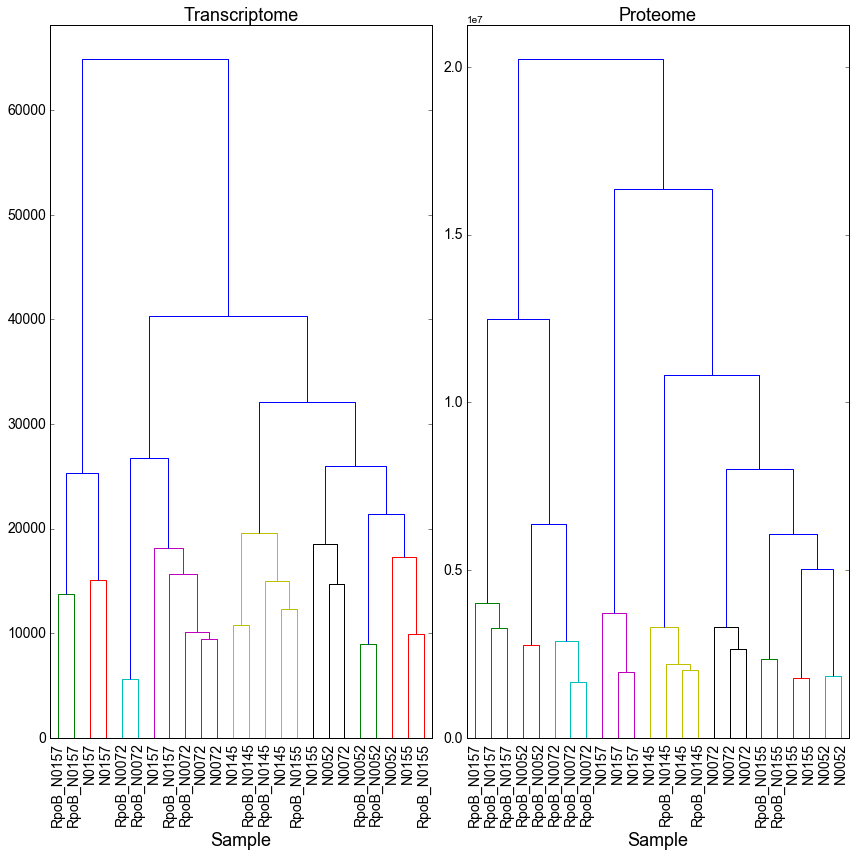

In [104]:
#generate the linkage matrices
RNASEQ_LINKAGE_11 = hierarchy.linkage(tbx11.TPM.T, 'ward')
PROTEOME_LINKAGE_11 = hierarchy.linkage(tbx11p.data.T, 'ward')

print(hierarchy.cophenet(RNASEQ_LINKAGE_11, pdist(tbx11.TPM.T))[0])
print(hierarchy.cophenet(PROTEOME_LINKAGE_11, pdist(tbx11p.data.T))[0])


plt.figure(figsize=(12,12))
plt.subplot(121)
hierarchy.dendrogram(RNASEQ_LINKAGE_11, leaf_rotation=90, 
                     leaf_font_size=axis_size, labels=tbx11.name, 
                     color_threshold=20000,)
plt.xlabel('Sample', size=label_size)
plt.yticks(size=axis_size)
plt.title('Transcriptome', size=18)

plt.subplot(122)
hierarchy.dendrogram(PROTEOME_LINKAGE_11, leaf_rotation=90, 
                     leaf_font_size=axis_size, labels=tbx11p.name, 
                     color_threshold=0.5e7,)
plt.xlabel('Sample', size=label_size)
plt.yticks(size=axis_size)
plt.title('Proteome', size=18)
plt.tight_layout()

plt.show()


The separation of the samples echoes that of the EVOLUTION SET in that the transcriptomes are less structured than the proteomes. In the case of transcripts the main strucutre seems to come from the phyllogenetic signal with Lineage 1 strains [N0072 and N0157] separating from Lineage 2 strains [N0052, N0145 and N0155]. In the case of the proteome, biological replicates cluster together with rpoB mutants for N0052, N0072 and N0157 being more closely related to each other. Interestingly the samples from N0145 cluster closely with each other - reflecting the number of differentially expressed proteins between them [2].

Let's get an overview of all the differentially expressed gene overlapping between RNAseq and proteomics in each strain background.

In [138]:
#TbX011
n52 = set(tbx11.genes[tbx11.N0052_significant])
n72 = set(tbx11.genes[tbx11.N0072_significant])
n145 = set(tbx11.genes[tbx11.N0145_significant])
n155 = set(tbx11.genes[tbx11.N0155_significant])
n157 = set(tbx11.genes[tbx11.N0157_significant])
tbx11_rpoB = set(tbx11.genes[tbx11.DESeq_significant])
tbx11_all = set(tbx11.genes[tbx11.All_significant])

#TbX011 proteomes: keeping only genes that are in tbx11p
n52p = set(tbx11p.N0052_genes[tbx11p.N0052_significant])&set(tbx11p.genes)
n72p = set(tbx11p.N0072_genes[tbx11p.N0072_significant])&set(tbx11p.genes)
n145p = set(tbx11p.N0145_genes[tbx11p.N0145_significant])&set(tbx11p.genes)
n155p = set(tbx11p.N0155_genes[tbx11p.N0155_significant])&set(tbx11p.genes)
n157p = set(tbx11p.N0157_genes[tbx11p.N0157_significant])&set(tbx11p.genes)
tbx11_rpoBp = set(tbx11p.RpoB_genes[tbx11p.RpoB_significant])&set(tbx11p.genes)
tbx11_allp = set(tbx11p.All_genes[tbx11p.All_significant])&set(tbx11p.genes)

In [106]:
all_GENETIC_DIVERSITY_pairs = [('N0052',n52,n52p),('N0072',n72,n72p),('N0145',n145,n145p),('N0155',n155,n155p),('N0157',n157,n157p)]

for (_strain,_DE_RNA,_DE_protein) in all_GENETIC_DIVERSITY_pairs:
    print(f'Strain background {_strain}: RNA-DE {len(_DE_RNA)}, Protein-DE {len(_DE_protein)}, OVERLAP: {len(_DE_RNA&_DE_protein)} [{np.round(len(_DE_RNA&_DE_protein)/len(_DE_RNA|_DE_protein)*100,1)}%]')

Strain background N0052: RNA-DE 41, Protein-DE 983, OVERLAP: 14 [1.4%]
Strain background N0072: RNA-DE 464, Protein-DE 1094, OVERLAP: 138 [9.7%]
Strain background N0145: RNA-DE 3, Protein-DE 2, OVERLAP: 0 [0.0%]
Strain background N0155: RNA-DE 421, Protein-DE 654, OVERLAP: 74 [7.4%]
Strain background N0157: RNA-DE 236, Protein-DE 1784, OVERLAP: 100 [5.2%]


Overall, it's clear that the two compartments do not respond in the same way to the presence of the RIF-R mutation.

Next, let's look at the dysregulation of the IdeR cluster. First the RNA and then the proteome.

## IdeR module expression

### RNAseq

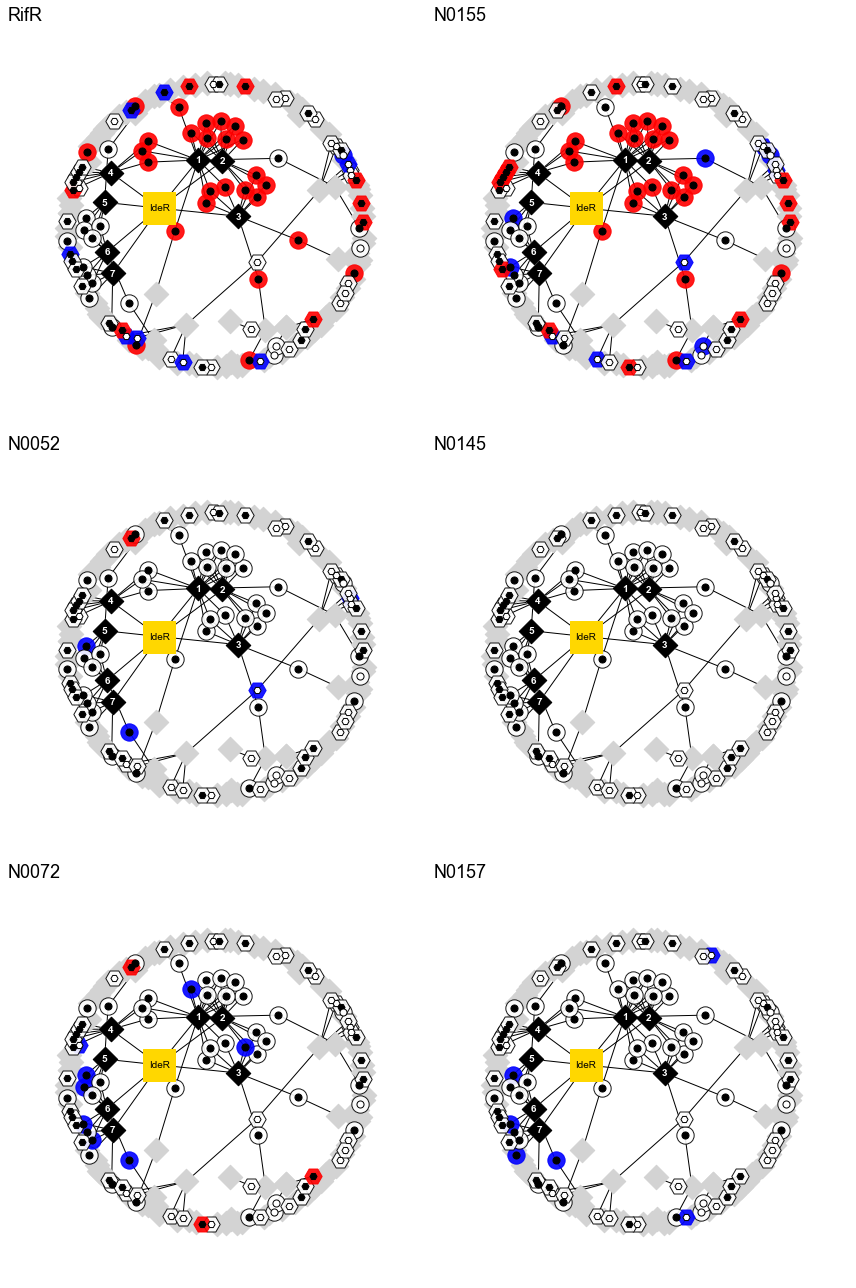

In [120]:
titles = ['RifR', 'N0155', 'N0052', 'N0145', 'N0072', 'N0157']

colours = {-1: ['red','red'], 1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,18) )

ax = plt.subplot(3,2,1)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    if gene in tbx8.DESeq_genes[tbx8.DESeq_significant]: 
        colour_it = np.sign(tbx8.DESeq_data[np.where(tbx8.DESeq_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
    a.set_edgecolor(colours.get(colour_it)[1])
    
for gene in fe:
    colour_it = 0
    if gene in tbx8.DESeq_genes[tbx8.DESeq_significant]: 
        colour_it = np.sign(tbx8.DESeq_data[np.where(tbx8.DESeq_genes==gene)[0][0]][1])
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color='white', font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.title(titles[0],size=title_size,loc='left')

for ind,de in enumerate(titles[1:]):
    ax = plt.subplot(3,2,ind+2)

    module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
    module_nodes.set_edgecolor('lightgrey')

    for gene in ider:
        colour_it = 0
        if gene in tbx11[f'{de}_genes'][tbx11[f'{de}_significant']]: 
            colour_it = np.sign(tbx11[f'{de}_data'][np.where(tbx11[f'{de}_genes']==gene)[0][0]][1])
        a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
        a.set_edgecolor(colours.get(colour_it)[1])

    for gene in fe:
        colour_it = 0
        if gene in tbx11[f'{de}_genes'][tbx11[f'{de}_significant']]: 
            colour_it = np.sign(tbx11[f'{de}_data'][np.where(tbx11[f'{de}_genes']==gene)[0][0]][1])
        a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
        a.set_edgecolor(colours.get(colour_it)[1])


    fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
    fu.set_edgecolor('black')
    fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
    fd.set_edgecolor('black')
    iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
    iu.set_edgecolor('black')
    il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
    il.set_edgecolor('black')

    figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                     'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                     'Module_446':'4'}

    nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                           node_color='black', node_shape='D')

    nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                            font_size=10, font_family='Arial',
                            font_color='white', font_weight='bold')

    ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                       node_shape='s',node_size=1000)
    ider_node.set_edgecolor('gold')

    nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


    nx.draw_networkx_edges(G2, posG2)

    #remove the frame
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
    plt.title(titles[ind+1],size=title_size,loc='left')

plt.tight_layout()    

Clearly, N0155 recapitulates the RifR data providing a confirmation for the robustness of our data. However none of the other strains have the same transcriptomic effect.

Next let's look at the proteome.

### Proteome

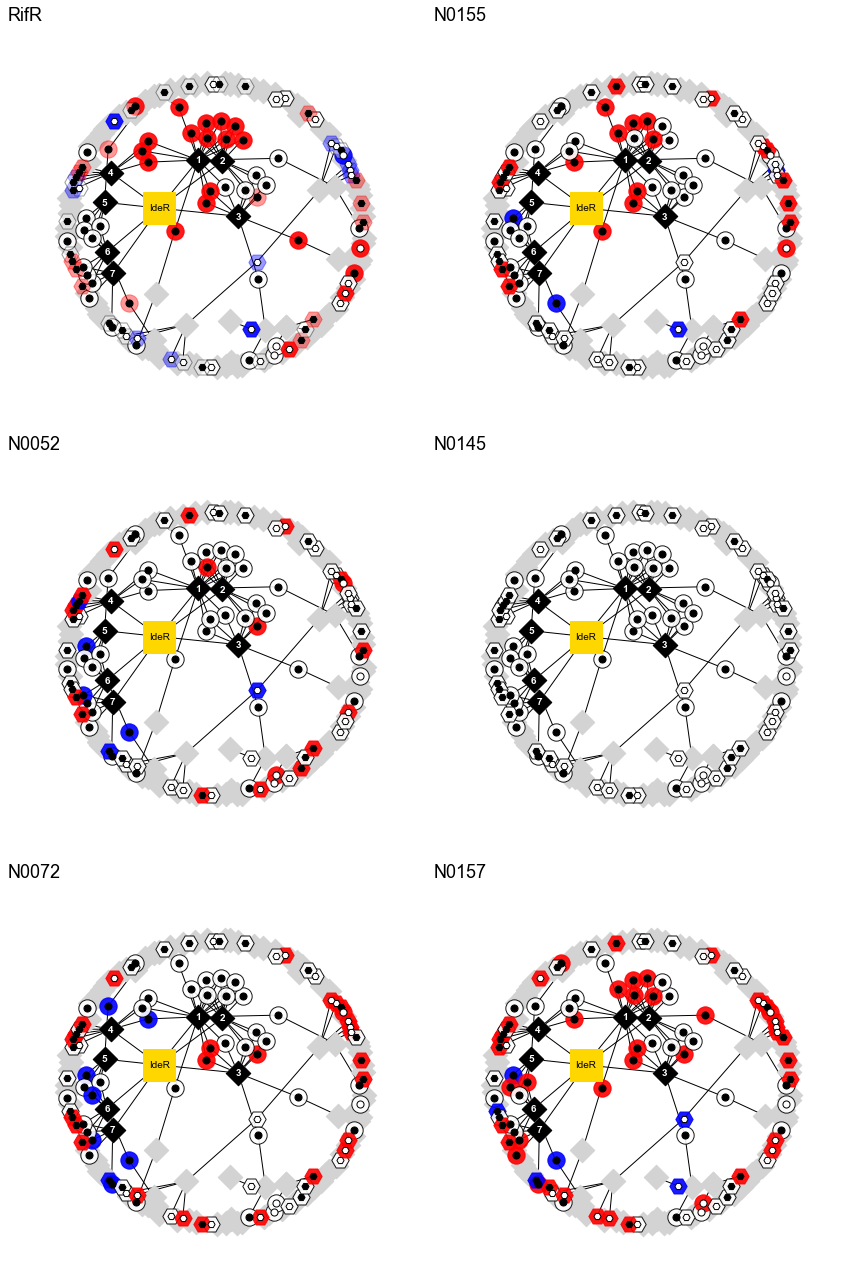

In [124]:
titles = ['RifR', 'N0155', 'N0052', 'N0145', 'N0072', 'N0157']

colours = {1: ['red','red'], -1: ['blue','blue'], 0: ['white','black']}

plt.figure(figsize=(12,18) )

ax = plt.subplot(3,2,1)

module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
module_nodes.set_edgecolor('lightgrey')

for gene in ider:
    colour_it = 0
    _alpha=0.9
    if gene in tbx8p.MSstats_genes:
        if tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]<0.05: 
            colour_it = np.sign(tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][0])
        if tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]>=0.05 and tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]<0.1: 
            colour_it = np.sign(tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][0])
            _alpha=0.4
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=_alpha)
    a.set_edgecolor(colours.get(colour_it)[1])

    
for gene in fe:
    colour_it = 0
    if gene in tbx8p.MSstats_genes:
        if tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]<0.05: 
            colour_it = np.sign(tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][0])
        if tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]>=0.05 and tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][5]<0.1: 
            colour_it = np.sign(tbx8p.MSstats_data[np.where(tbx8p.MSstats_genes==gene)[0][0]][0])
            _alpha=0.4
    a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=_alpha,node_shape='H')
    a.set_edgecolor(colours.get(colour_it)[1])

    
fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
fu.set_edgecolor('black')
fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
fd.set_edgecolor('black')
iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
iu.set_edgecolor('black')
il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
il.set_edgecolor('black')

figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                 'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                 'Module_446':'4'}

nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                       node_color='black', node_shape='D',)

nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                        font_size=10, font_family='Arial',
                        font_color=('white'), font_weight='bold')

ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                   node_shape='s',node_size=1000)
ider_node.set_edgecolor('gold')

nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


nx.draw_networkx_edges(G2, posG2)

#remove the frame
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.yaxis.set_ticks_position('none')
ax.xaxis.set_ticks_position('none')
ax.xaxis.set_ticks([])
ax.yaxis.set_ticks([])

plt.title(titles[0],size=title_size,loc='left')

for ind,de in enumerate(titles[1:]):
    ax = plt.subplot(3,2,ind+2)

    module_nodes = nx.draw_networkx_nodes(G2, posG2, ider_modules+fe_modules,                                       
                                      node_color='lightgrey', 
                                      node_shape='D',)
    module_nodes.set_edgecolor('lightgrey')

    for gene in ider:
        colour_it = 0
        if gene in tbx11p[f'{de}_genes']:
            if tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]<0.05: 
                colour_it = np.sign(tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][0])
            if tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]>=0.05 and tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]<0.1: 
                colour_it = np.sign(tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][0])
                _alpha=0.4
#         if gene in tbx11[f'{de}_genes'][tbx11[f'{de}_significant']]: 
#             colour_it = np.sign(tbx11[f'{de}_data'][np.where(tbx11[f'{de}_genes']==gene)[0][0]][1])
        a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9)
        a.set_edgecolor(colours.get(colour_it)[1])

    for gene in fe:
        colour_it = 0
        if gene in tbx11p[f'{de}_genes']:
            if tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]<0.05: 
                colour_it = np.sign(tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][0])
            if tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]>=0.05 and tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][5]<0.1: 
                colour_it = np.sign(tbx11p[f'{de}_data'][np.where(tbx11p[f'{de}_genes']==gene)[0][0]][0])
                _alpha=0.4
        a = nx.draw_networkx_nodes(G2, posG2, [gene], node_color=colours.get(colour_it)[0],alpha=0.9,node_shape='H')
        a.set_edgecolor(colours.get(colour_it)[1])


    fu = nx.draw_networkx_nodes(G2, posG2, fe_induced, node_color='white', node_size=50, node_shape='H')
    fu.set_edgecolor('black')
    fd = nx.draw_networkx_nodes(G2, posG2, fe_repressed, node_color='black', node_size=50, node_shape='H')
    fd.set_edgecolor('black')
    iu = nx.draw_networkx_nodes(G2, posG2, ider_induced, node_color='white', node_size=50, node_shape='o')
    iu.set_edgecolor('black')
    il = nx.draw_networkx_nodes(G2, posG2, ider_repressed, node_color='black', node_size=50, node_shape='o')
    il.set_edgecolor('black')

    figure_labels = {'Module_502':'1', 'Module_525':'2','Module_267':'3', 
                     'Module_086':'6', 'Module_231':'5', 'Module_295':'7', 
                     'Module_446':'4'}

    nx.draw_networkx_nodes(G2, posG2, figure_labels.keys(),                                       
                           node_color='black', node_shape='D')

    nx.draw_networkx_labels(G2, posG2, labels=figure_labels,
                            font_size=10, font_family='Arial',
                            font_color='white', font_weight='bold')

    ider_node = nx.draw_networkx_nodes(G2, posG2, ['IdeR'], node_color='gold', 
                                       node_shape='s',node_size=1000)
    ider_node.set_edgecolor('gold')

    nx.draw_networkx_labels(G2, posG2, labels={'IdeR':'IdeR'},
                        font_size=10, font_family='Arial',
                        font_color='black')


    nx.draw_networkx_edges(G2, posG2)

    #remove the frame
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.xaxis.set_ticks_position('none')
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    
    plt.title(titles[ind+1],size=title_size,loc='left')

plt.tight_layout()    

There are more commnalities on the proteome level. Let's have a look at whether there is a shared enrichment of any of the transcriptional modules.

First, check how many of the genes attributed to modules by Peterson et al., are also in our dataset.

In [128]:
modules['IN_PROTEOME'] = [int(x in tbx11p.N0157_genes) for x in modules.Gene]
modules['IN_TRANSCRIPTOME'] = [int(x in tbx11p.N0157_genes) for x in modules.Gene]

modules.head()

,Module_ID,Gene,IN_PROTEOME,IN_TRANSCRIPTOME
0,Module_001,Rv0830,1,1
1,Module_001,Rv2377c,1,1
2,Module_001,Rv2963,1,1
3,Module_001,Rv2975c,0,0
4,Module_001,Rv3848,0,0


Make new dataframe containing information regarding all the significantly differentially expressed genes.

In [147]:
modules_with_data = modules.copy()

for (_significant_genes,label) in zip([n52,n72,n145,n155,n157,tbx11_all],['N0052','N0072','N0145','N0155','N0157','ALL']):
    label=label+'_RNA'
    modules_with_data[label] = [int(x in _significant_genes) for x in modules_with_data.Gene]
    
for (_significant_genes,label) in zip([n52p,n72p,n145p,n155p,n157p,tbx11_allp],['N0052','N0072','N0145','N0155','N0157','ALL']):
    label=label+'_PROTEIN'
    modules_with_data[label] = [int(x in _significant_genes) for x in modules_with_data.Gene]

modules_with_data.head()

,Module_ID,Gene,IN_PROTEOME,IN_TRANSCRIPTOME,N0052_RNA,N0072_RNA,N0145_RNA,N0155_RNA,N0157_RNA,ALL_RNA,N0052_PROTEIN,N0072_PROTEIN,N0145_PROTEIN,N0155_PROTEIN,N0157_PROTEIN,ALL_PROTEIN
0,Module_001,Rv0830,1,1,0,0,0,0,1,0,0,0,0,0,0,1
1,Module_001,Rv2377c,1,1,0,0,0,1,0,0,0,0,0,0,1,0
2,Module_001,Rv2963,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,Module_001,Rv2975c,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Module_001,Rv3848,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now that we have all the data re-formatted, let's go and have a look at over-represented modules.

In [148]:
come_on = {k:{} for k,v in Counter(modules.Module_ID).items() if v>4}

all_transcripts = len(Counter(modules_with_data.Gene[modules_with_data.IN_TRANSCRIPTOME==1]))
all_proteins = len(Counter(modules_with_data.Gene[modules_with_data.IN_PROTEOME==1]))

_first_pass = True
for _sample in modules_with_data.columns[4:10]:
    _sample_significant = len(Counter(modules_with_data.Gene[(modules_with_data[_sample]==1)]))
    for _module in come_on.keys():
        if _first_pass:
            come_on[_module]['RNA_MODULE_SIZE'] = len(Counter(modules_with_data.Gene[(modules_with_data.IN_TRANSCRIPTOME==1)&(modules_with_data.Module_ID==_module)]))
        _module_significant = modules_with_data[_sample][modules_with_data.Module_ID==_module].sum()
        _module_size = come_on[_module]['RNA_MODULE_SIZE']
        o,p = ss.fisher_exact([[_module_significant,_module_size],
                               [_sample_significant-_module_significant,all_transcripts-_module_size]], alternative='greater')
        come_on[_module][_sample+'_ODDS'] = o
        come_on[_module][_sample+'_PVAL'] = p
        if _module == 'Module_001':
            print(_sample)
    _first_pass = False
    
_first_pass = True
for _sample in modules_with_data.columns[10:]:
    _sample_significant = len(Counter(modules_with_data.Gene[(modules_with_data[_sample]==1)]))
    for _module in come_on.keys():
        if _first_pass:
            come_on[_module]['PROTEIN_MODULE_SIZE'] = len(Counter(modules_with_data.Gene[(modules_with_data.IN_PROTEOME==1)&(modules_with_data.Module_ID==_module)]))
        _module_significant = modules_with_data[_sample][modules_with_data.Module_ID==_module].sum()
        _module_size = come_on[_module]['PROTEIN_MODULE_SIZE']
        o,p = ss.fisher_exact([[_module_significant,_module_size],
                               [_sample_significant-_module_significant,all_proteins-_module_size]])
        come_on[_module][_sample+'_ODDS'] = o
        come_on[_module][_sample+'_PVAL'] = p
        if _module == 'Module_001':
            print(_sample)
    _first_pass = False
    
module_enrichment = pd.DataFrame(come_on).T
module_enrichment.head()

N0052_RNA
N0072_RNA
N0145_RNA
N0155_RNA
N0157_RNA
ALL_RNA
N0052_PROTEIN
N0072_PROTEIN
N0145_PROTEIN
N0155_PROTEIN
N0157_PROTEIN
ALL_PROTEIN


,RNA_MODULE_SIZE,N0052_RNA_ODDS,N0052_RNA_PVAL,N0072_RNA_ODDS,N0072_RNA_PVAL,N0145_RNA_ODDS,N0145_RNA_PVAL,N0155_RNA_ODDS,N0155_RNA_PVAL,N0157_RNA_ODDS,...,N0072_PROTEIN_ODDS,N0072_PROTEIN_PVAL,N0145_PROTEIN_ODDS,N0145_PROTEIN_PVAL,N0155_PROTEIN_ODDS,N0155_PROTEIN_PVAL,N0157_PROTEIN_ODDS,N0157_PROTEIN_PVAL,ALL_PROTEIN_ODDS,ALL_PROTEIN_PVAL
Module_001,3.0,0.0,1.0,0.000000,1.000000,0.0,1.0,2.276167,0.421679,4.027066,...,0.000000,0.565382,0.0,1.0,0.000000,1.000000,0.533296,1.000000,0.560246,1.000000
Module_002,6.0,0.0,1.0,1.027656,0.651175,0.0,1.0,0.000000,1.000000,0.000000,...,0.869191,1.000000,0.0,1.0,0.726337,1.000000,1.602724,0.553886,1.121302,1.000000
Module_003,9.0,0.0,1.0,0.684377,0.778048,0.0,1.0,0.757112,0.746001,4.053161,...,0.578845,0.737808,0.0,1.0,0.000000,0.224244,0.354977,0.221891,0.559722,0.552751
Module_004,7.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.000000,1.000000,0.000000,...,0.372035,0.457431,0.0,1.0,0.622354,1.000000,0.914480,1.000000,0.479816,0.498374
Module_005,8.0,0.0,1.0,0.000000,1.000000,0.0,1.0,0.852053,0.708635,0.000000,...,2.290584,0.143293,0.0,1.0,1.638158,0.440753,1.402186,0.597448,1.473300,0.438213


Plot the results for the modules that have a fisher's exact p<0.01 in at least one category.

Plot the IdeR-modules separately.

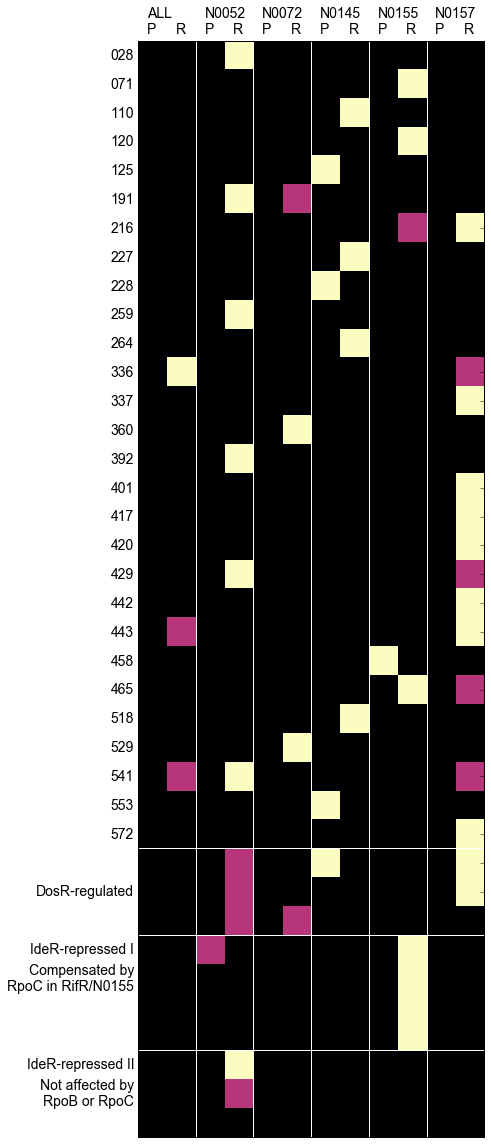

In [149]:
pval_columns = sorted([x for x in module_enrichment.columns if 'PVAL' in x])
fe_modules = ['Module_502','Module_525','Module_267','Module_446',
              'Module_231','Module_086', 'Module_295']

dosR_modules = ['Module_035','Module_224','Module_404']

pe_ppe_modules = ['Module_194'] #skip this as it is not valid RNAseq data

fe_labels = ['IdeR-repressed I','Compensated by\nRpoC in RifR/N0155','','','IdeR-repressed II','Not affected by\nRpoB or RpoC','']
dosR_labels = ['','DosR-regulated','']
sig_modules = [x for x in module_enrichment.index[np.where(module_enrichment[pval_columns].min(axis=1)<0.01)] if x not in dosR_modules+fe_modules+pe_ppe_modules]

plot_this = module_enrichment[pval_columns][module_enrichment.index.isin(sig_modules)].values
plot_this_binary = np.zeros(shape=(38,12))
plot_this_binary[np.where(plot_this<0.05)]+=.5
plot_this_binary[np.where(plot_this<0.01)]+=.5
for ind,val in enumerate(dosR_modules+fe_modules):
    plot_this_binary[ind+28,[np.where(module_enrichment[pval_columns][module_enrichment.index==val].values[0]<0.05)][0]]+=.5
    plot_this_binary[ind+28,[np.where(module_enrichment[pval_columns][module_enrichment.index==val].values[0]<0.01)][0]]+=.5

plt.figure(figsize=(8,16))
#plt.imshow(np.log10(plot_this),vmin=-2,vmax=0)
#plt.colorbar()
plt.imshow(plot_this_binary, cmap='magma',interpolation='none')

plt.tick_params(axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False, # labels along the bottom edge are off
                labeltop=True)

plt.xticks(np.arange(-0.2,11,1),
           ['ALL\nP','R','N0052\nP','R','N0072\nP','R','N0145\nP','R','N0155\nP','R','N0157\nP','R'],
           size=axis_size, horizontalalignment='left')
#['ALL']+[x[:5] for x in modules_with_data.columns[4:9]], 

plt.yticks(np.arange(38),
           [x[-3:] for x in sig_modules]+dosR_labels+fe_labels,
           size=axis_size)
#plt.ylabel('Transcriptional Modules', size=18, verticalalignment='top')
plt.vlines([1.5,3.5,5.5,7.5,9.5],[-0.5,]*5, [37.5,]*5, colors='white')
plt.hlines([27.5,30.5,34.5],[-.5,]*2,[11.5,]*2, colors='white')
plt.tight_layout()

Clearly the combined analysis yields very little, while individual strains have private signatures of cost. A handful of modules are highlighted in more than one strain. These are Module_502 and Module_231 both part of IdeR-repressed, Module_035 and Module_224 both DosR and finally Module_541 which is supposed to be regulated by Rv1049 and contains members of Mce and Nuo.

Importantly no modules are significantly enriched for both the Proteome and the RNA significant hits.

That is consistent with what we saw earlier when comparing the proteome and transcriptome perturbations finding on average a 10% overlap.

Let get the comparisons for the Venn diagrams.

First the transcriptomic data and then the proteomic data.

In [151]:
rpoB_sigs_11 = [set(n72), set(n157), set(n52), set(n145), set(n155)]
rpoB_sigs_labels = ['N0072', 'N0157', 'N0052', 'N0145', 'N0155']

for ind,gset in enumerate(rpoB_sigs_11):
    for ind2 in range(ind+1,5,1):
        print(rpoB_sigs_labels[ind], 'vs.', rpoB_sigs_labels[ind2])
        print(len(rpoB_sigs_11[ind]), len(rpoB_sigs_11[ind2]), len(rpoB_sigs_11[ind]&rpoB_sigs_11[ind2]))

print('N0072 vs. N0157 vs. N0155')
print(len((set(n157)&set(n72)&set(n155))-set(n52)))
print('N0052 vs. N0157 vs. N0155')
print(len((set(n52)&set(n157)&set(n155))-set(n72)))
print('N0052 vs. N0072 vs. N0157')
print(len((set(n52)&set(n157)&set(n72))-set(n155)))
print('N0052 vs. N0072 vs. N0155')
print(len((set(n52)&set(n72)&set(n155))-set(n157)))
print('N0052 vs. N0072 vs. N0157 vs. N0155')
print(len(set(n52)&set(n157)&set(n72)&set(n155)))
print('N0052 vs. N0072 vs. N0157 vs. N0155 vs. N0145')
print(len(set(n52)&set(n157)&set(n72)&set(n155)&set(n145)))

N0072 vs. N0157
464 236 44
N0072 vs. N0052
464 41 14
N0072 vs. N0145
464 3 0
N0072 vs. N0155
464 421 77
N0157 vs. N0052
236 41 15
N0157 vs. N0145
236 3 0
N0157 vs. N0155
236 421 81
N0052 vs. N0145
41 3 0
N0052 vs. N0155
41 421 18
N0145 vs. N0155
3 421 0
N0072 vs. N0157 vs. N0155
16
N0052 vs. N0157 vs. N0155
0
N0052 vs. N0072 vs. N0157
1
N0052 vs. N0072 vs. N0155
4
N0052 vs. N0072 vs. N0157 vs. N0155
7
N0052 vs. N0072 vs. N0157 vs. N0155 vs. N0145
0


In [152]:
rpoB_sigs_11 = [set(n72p), set(n157p), set(n52p), set(n145p), set(n155p)]
rpoB_sigs_labels = ['N0072', 'N0157', 'N0052', 'N0145', 'N0155']

for ind,gset in enumerate(rpoB_sigs_11):
    for ind2 in range(ind+1,5,1):
        print(rpoB_sigs_labels[ind], 'vs.', rpoB_sigs_labels[ind2])
        print(len(rpoB_sigs_11[ind]), len(rpoB_sigs_11[ind2]), len(rpoB_sigs_11[ind]&rpoB_sigs_11[ind2]))

print('N0072 vs. N0157 vs. N0155')
print(len((set(n157p)&set(n72p)&set(n155p))-set(n52p)))
print('N0052 vs. N0157 vs. N0155')
print(len((set(n52p)&set(n157p)&set(n155p))-set(n72p)))
print('N0052 vs. N0072 vs. N0157')
print(len((set(n52p)&set(n157p)&set(n72p))-set(n155p)))
print('N0052 vs. N0072 vs. N0155')
print(len((set(n52p)&set(n72p)&set(n155p))-set(n157p)))
print('N0052 vs. N0072 vs. N0157 vs. N0155')
print(len(set(n52p)&set(n157p)&set(n72p)&set(n155p)))
print('N0052 vs. N0072 vs. N0157 vs. N0155 vs. N0145')
print(len(set(n52p)&set(n157p)&set(n72p)&set(n155p)&set(n145p)))

N0072 vs. N0157
1094 1784 969
N0072 vs. N0052
1094 983 759
N0072 vs. N0145
1094 2 1
N0072 vs. N0155
1094 654 538
N0157 vs. N0052
1784 983 908
N0157 vs. N0145
1784 2 1
N0157 vs. N0155
1784 654 596
N0052 vs. N0145
983 2 1
N0052 vs. N0155
983 654 541
N0145 vs. N0155
2 654 1
N0072 vs. N0157 vs. N0155
37
N0052 vs. N0157 vs. N0155
43
N0052 vs. N0072 vs. N0157
254
N0052 vs. N0072 vs. N0155
8
N0052 vs. N0072 vs. N0157 vs. N0155
481
N0052 vs. N0072 vs. N0157 vs. N0155 vs. N0145
1


Puzzling result with as many as 481 differentially expressed proteins shared across 4 strains.

Let's look at this more broadly, both from the perspective of genetic distance and more global expression perturbations.

In [153]:
genetic_distance = pd.read_table('../data/SNP_distances_ref_strains_sorted.txt',index_col=0) #From Borrell et al., PLoS ONE 2019
genetic_distance.head()

,N0004,N0031,N0052,N0054,N0072,N0091,N0136,N0145,N0153,N0155,N0157,N1063,N1176,N1177,N1202,N1216,N1272,N1274,N1283
N0004,0,1166,1162,390,1850,2071,1213,1139,1796,1109,1768,1921,1926,2057,2008,1183,1956,356,1200
N0031,1166,0,866,1199,1844,2120,1254,230,1776,240,1749,1955,1978,2107,2062,1241,1986,1202,1258
N0052,1162,866,0,1193,1834,2104,1246,234,1786,246,1748,1948,1965,2083,2036,1218,1976,1188,1244
N0054,390,1199,1193,0,1881,2053,1219,1169,1829,1148,1801,1918,1903,2033,1978,1160,1944,383,1206
N0072,1850,1844,1834,1881,0,2054,1837,1840,812,1859,919,1916,1921,2032,1987,1778,1941,1882,1815


In [154]:
DE_data = {'N0052': {'genes': n52, 'index':[[0,1],[22,23]]}, 
           'N0072': {'genes': n72, 'index':[[2,3,4],[16,17,18]]}, 
           'N0145': {'genes': n145, 'index':[[5,6],[12,13]]},
           'N0155': {'genes': n155, 'index':[[7,8],[14,15]]},
           'N0157': {'genes': n157, 'index':[[9,10,11],[19,20,21]]}}

#Add genetic distance
for x in DE_data.keys():
    for y in DE_data.keys():
        if x!=y:
            DE_data[x][y] = int(genetic_distance[x][genetic_distance.index==y])
            
#Add DESeq2 lfc distance
strains = ['N0052', 'N0072', 'N0145','N0155','N0157']
DE_data['lfc'] = {}
for x in strains:
    DE_data['lfc'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.array(tbx11['{}_data'.format(x)][:,1])
            _y = np.array(tbx11['{}_data'.format(y)][:,1])
            DE_data['lfc'][x][y] = np.sqrt(np.sum((_x-_y)**2))
            
#Add TPM ratio euclidean distances
DE_data['TPM'] = {}
for x in strains:
    DE_data['TPM'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.mean(tbx11.TPM[:,DE_data[x]['index'][0]]/tbx11.TPM[:,DE_data[x]['index'][1]],axis=1)
            _y = np.mean(tbx11.TPM[:,DE_data[y]['index'][0]]/tbx11.TPM[:,DE_data[y]['index'][1]],axis=1)
            #lose 0s and infs
            _keep = np.where(np.invert(np.isinf(_x)+np.isnan(_x)+np.isinf(_y)+np.isnan(_y)))[0]
            DE_data['TPM'][x][y] = np.sqrt(np.sum((_x[_keep]-_y[_keep])**2))
            
#Add significantly DE genes for Manhattan/Hamming distance
DE_data['Manhattan'] = {}
DE_data['Hamming'] = {}
for x in strains:
    DE_data['Manhattan'][x] = {}
    DE_data['Hamming'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.zeros(len(tbx11['{}_genes'.format(x)]))
            _x[tbx11['{}_significant'.format(x)]]+=1
            _y = np.zeros(len(tbx11['{}_genes'.format(y)]))
            _y[tbx11['{}_significant'.format(y)]]+=1
            DE_data['Manhattan'][x][y] = sp.spatial.distance.cityblock(_x,_y)
            DE_data['Hamming'][x][y] = sp.spatial.distance.hamming(_x,_y)

RNASEQ DATA

SpearmanrResult(correlation=0.362677131698819, pvalue=0.30301987922564816)
6.695504967638616 0.12151277316331982 0.3235639044101065
120.28699089287107
SpearmanrResult(correlation=0.23636363636363633, pvalue=0.5108853175152002)
24.951184459493682 0.05111798645757653 0.5299377069757041
16.585072566416084
SpearmanrResult(correlation=0.5878787878787878, pvalue=0.07387770688865801)
0.07828456754375313 0.10066845052342084 0.37169415117928956
44.86291896263001

PROTEOME DATA 

SpearmanrResult(correlation=0.1875916198442167, pvalue=0.6037816838313677)
257.4574081585556 0.0704169587881986 0.45869829506597404
87.17389421651225
SpearmanrResult(correlation=-0.24848484848484845, pvalue=0.48877630451924314)
645.8925840906916 0.057957040759951166 0.5028502606591607
60.11666076671753
SpearmanrResult(correlation=0.17575757575757575, pvalue=0.6271883447764844)
0.24842085567057937 0.1333122218423145 0.2995310647107796
37.894084607165404


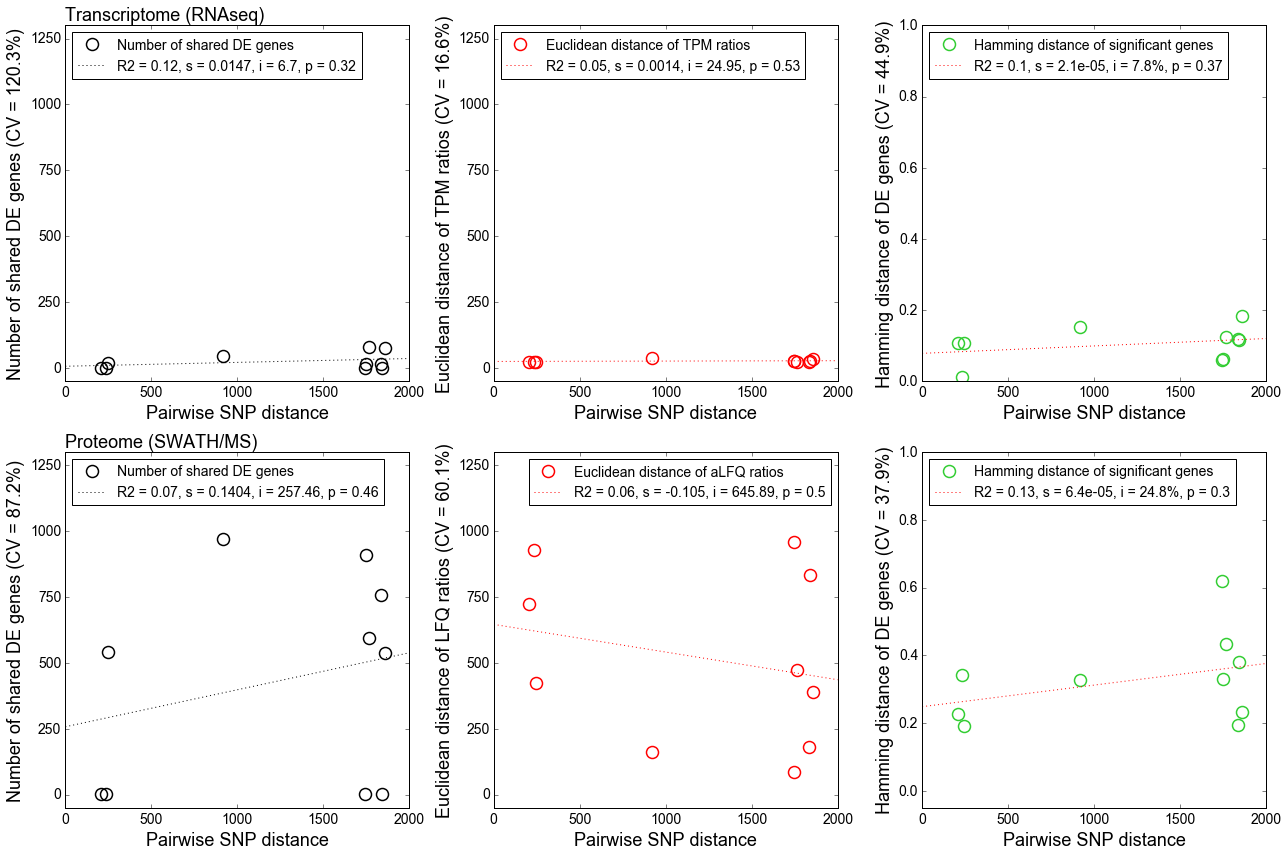

In [156]:
plt.figure(figsize=(18,12))

###############
# RNASEQ DATA #
###############

DE_data = {'N0052': {'genes': n52, 'index':[[0,1],[22,23]]}, 
           'N0072': {'genes': n72, 'index':[[2,3,4],[16,17,18]]}, 
           'N0145': {'genes': n145, 'index':[[5,6],[12,13]]},
           'N0155': {'genes': n155, 'index':[[7,8],[14,15]]},
           'N0157': {'genes': n157, 'index':[[9,10,11],[19,20,21]]}}

#Add genetic distance
for x in DE_data.keys():
    for y in DE_data.keys():
        if x!=y:
            DE_data[x][y] = int(genetic_distance[x][genetic_distance.index==y])
            
#Add DESeq2 lfc distance
strains = ['N0052', 'N0072', 'N0145','N0155','N0157']
DE_data['lfc'] = {}
for x in strains:
    DE_data['lfc'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.array(tbx11['{}_data'.format(x)][:,1])
            _y = np.array(tbx11['{}_data'.format(y)][:,1])
            DE_data['lfc'][x][y] = np.sqrt(np.sum((_x-_y)**2))
            
#Add TPM ratio euclidean distances
DE_data['TPM'] = {}
for x in strains:
    DE_data['TPM'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.mean(tbx11.TPM[:,DE_data[x]['index'][0]]/tbx11.TPM[:,DE_data[x]['index'][1]],axis=1)
            _y = np.mean(tbx11.TPM[:,DE_data[y]['index'][0]]/tbx11.TPM[:,DE_data[y]['index'][1]],axis=1)
            #lose 0s and infs
            _keep = np.where(np.invert(np.isinf(_x)+np.isnan(_x)+np.isinf(_y)+np.isnan(_y)))[0]
            DE_data['TPM'][x][y] = np.sqrt(np.sum((_x[_keep]-_y[_keep])**2))
            
#Add significantly DE genes for Manhattan/Hamming distance
DE_data['Manhattan'] = {}
DE_data['Hamming'] = {}
for x in strains:
    DE_data['Manhattan'][x] = {}
    DE_data['Hamming'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.zeros(len(tbx11['{}_genes'.format(x)]))
            _x[tbx11['{}_significant'.format(x)]]+=1
            _y = np.zeros(len(tbx11['{}_genes'.format(y)]))
            _y[tbx11['{}_significant'.format(y)]]+=1
            DE_data['Manhattan'][x][y] = sp.spatial.distance.cityblock(_x,_y)
            DE_data['Hamming'][x][y] = sp.spatial.distance.hamming(_x,_y)

###############
# RNASEQ PLOT #
###############

distances = []
overlap = []
lfc = []
tpm = []
mnht = []
hamm = []

for ind,x in enumerate(strains):
    for y in strains[ind+1:]:
        overlap.append(len(DE_data[x]['genes']&DE_data[y]['genes']))
        distances.append(DE_data[x][y])
        lfc.append(DE_data['lfc'][x][y])
        tpm.append(DE_data['TPM'][x][y])
        mnht.append(DE_data['Manhattan'][x][y])
        hamm.append(DE_data['Hamming'][x][y])
        
plt.subplot(231)

print('RNASEQ DATA\n')

plt.plot(distances, overlap, 'o', mec='black', mew=1.5, mfc='none', ms=12, label='Number of shared DE genes')
s,i,r,p,e = ss.linregress(distances,overlap)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'k:',
         label='R2 = {}, s = {}, i = {}, p = {}'.format(np.round(r**2,2),np.round(s,4), np.round(i,2), np.round(p,2)))
plt.ylim(-50,1300)
plt.yticks(np.arange(0,1260,250), size=14)
plt.legend(loc=2, fontsize=14)
#plt.ylim(-1,100)
#plt.yticks(np.arange(0,110,25), size=14)
plt.title('Transcriptome (RNAseq)', size=title_size, loc='left')
plt.ylabel('Number of shared DE genes (CV = {}%)'.format(np.round(np.std(overlap)/np.mean(overlap)*100,1)), size=18)
plt.xlim(0,2000)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)

print(ss.spearmanr(distances,overlap))
print(i,r**2,p)
print(np.std(overlap)/np.mean(overlap)*100)


plt.subplot(232)
#plt.twinx()

plt.plot(distances, tpm, 'o', mec='red', mew=1.5, mfc='none', ms=12, label='Euclidean distance of TPM ratios')
s,i,r,p,e = ss.linregress(distances,tpm)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'r:', 
         label='R2 = {}, s = {}, i = {}, p = {}'.format(np.round(r**2,2),np.round(s,4), np.round(i,2), np.round(p,2)))
plt.ylim(-50,1300)
plt.yticks(np.arange(0,1260,250), size=14)
plt.legend(loc=2, fontsize=14)
#plt.ylim(0,40)
#plt.yticks(np.arange(0,50,20),size=14)
#plt.legend(loc=4, fontsize=14)
plt.ylabel('Euclidean distance of TPM ratios (CV = {}%)'.format(np.round(np.std(tpm)/np.mean(tpm)*100,1)), size=18)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)
print(ss.spearmanr(distances,tpm))
print(i,r**2,p)
print(np.std(tpm)/np.mean(tpm)*100)

plt.subplot(233)
#plt.twinx()

plt.plot(distances, hamm, 'o', mec='limegreen', mew=1.5, mfc='none', ms=12, label='Hamming distance of significant genes')
s,i,r,p,e = ss.linregress(distances,hamm)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'r:', 
         label='R2 = {}, s = {}, i = {}%, p = {}'.format(np.round(r**2,2),np.round(s,6), np.round(i*100,1), np.round(p,2)))
plt.ylim(0,1)
plt.yticks(np.arange(0,1.1,.2),size=14)
#plt.ylim(0,0.2)
#plt.yticks(np.arange(0,0.21,.1),size=14)
plt.legend(loc=2, fontsize=14)
plt.ylabel('Hamming distance of DE genes (CV = {}%)'.format(np.round(np.std(hamm)/np.mean(hamm)*100,1)), size=18)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)
print(ss.spearmanr(distances,hamm))
print(i,r**2,p)
print(np.std(hamm)/np.mean(hamm)*100)

plt.tight_layout()

#################
# PROTEOME DATA #
#################

DE_data = {'N0052': {'genes': n52p, 'index':[[0,1],[22,23]]}, 
           'N0072': {'genes': n72p, 'index':[[2,3,4],[16,17,18]]}, 
           'N0145': {'genes': n145p, 'index':[[5,6],[12,13]]},
           'N0155': {'genes': n155p, 'index':[[7,8],[14,15]]},
           'N0157': {'genes': n157p, 'index':[[9,10,11],[19,20,21]]}}

#Add genetic distance
for x in DE_data.keys():
    for y in DE_data.keys():
        if x!=y:
            DE_data[x][y] = int(genetic_distance[x][genetic_distance.index==y])
            
#Add MSstats lfc distance
strains = ['N0052', 'N0072', 'N0145','N0155','N0157']
DE_data['lfc'] = {}
for x in strains:
    DE_data['lfc'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.array(tbx11p['{}_data'.format(x)][:,0])
            _y = np.array(tbx11p['{}_data'.format(y)][:,0])
            DE_data['lfc'][x][y] = np.sqrt(np.sum((_x-_y)**2))
            
#Add aFLQ ratio euclidean distances
DE_data['aLFQ'] = {}
for x in strains:
    DE_data['aLFQ'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.mean(tbx11p.data[:,DE_data[x]['index'][0]]/tbx11p.data[:,DE_data[x]['index'][1]],axis=1)
            _y = np.mean(tbx11p.data[:,DE_data[y]['index'][0]]/tbx11p.data[:,DE_data[y]['index'][1]],axis=1)
            #lose 0s and infs
            _keep = np.where(np.invert(np.isinf(_x)+np.isnan(_x)+np.isinf(_y)+np.isnan(_y)))[0]
            DE_data['aLFQ'][x][y] = np.sqrt(np.sum((_x[_keep]-_y[_keep])**2))
            
#Add significantly DE genes for Manhattan/Hamming distance
DE_data['Manhattan'] = {}
DE_data['Hamming'] = {}
for x in strains:
    DE_data['Manhattan'][x] = {}
    DE_data['Hamming'][x] = {}
    for y in strains:
        if x!=y:
            _x = np.zeros(len(tbx11p['{}_genes'.format(x)]))
            _x_index = [int(np.where(tbx11p.genes==_gene)[0]) for _gene in DE_data[x]['genes'] if _gene not in ['Rv2090','Rv2442c']]
            _x[_x_index]+=1
            _y = np.zeros(len(tbx11p['{}_genes'.format(y)]))
            _y_index = [int(np.where(tbx11p.genes==_gene)[0]) for _gene in DE_data[y]['genes'] if _gene not in ['Rv2090','Rv2442c']]
            _y[_y_index]+=1
            DE_data['Manhattan'][x][y] = sp.spatial.distance.cityblock(_x,_y)
            DE_data['Hamming'][x][y] = sp.spatial.distance.hamming(_x,_y)
            
#################
# PROTEOME PLOT #
#################
distances = []
overlap = []
lfc = []
tpm = []
mnht = []
hamm = []

for ind,x in enumerate(strains):
    for y in strains[ind+1:]:
        overlap.append(len(DE_data[x]['genes']&DE_data[y]['genes']))
        distances.append(DE_data[x][y])
        lfc.append(DE_data['lfc'][x][y])
        tpm.append(DE_data['aLFQ'][x][y])
        mnht.append(DE_data['Manhattan'][x][y])
        hamm.append(DE_data['Hamming'][x][y])

print('\nPROTEOME DATA \n')

plt.subplot(234)
plt.plot(distances, overlap, 'o', mec='black', mew=1.5, mfc='none', ms=12, label='Number of shared DE genes')
s,i,r,p,e = ss.linregress(distances,overlap)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'k:',
         label='R2 = {}, s = {}, i = {}, p = {}'.format(np.round(r**2,2),np.round(s,4), np.round(i,2), np.round(p,2)))
plt.ylim(-50,1300)
plt.yticks(np.arange(0,1260,250), size=14)
plt.legend(loc=2, fontsize=14)
plt.ylabel('Number of shared DE genes (CV = {}%)'.format(np.round(np.std(overlap)/np.mean(overlap)*100,1)), size=18)
plt.xlim(0,2000)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)
plt.title('Proteome (SWATH/MS)', size=title_size, loc='left')

print(ss.spearmanr(distances,overlap))
print(i,r**2,p)
print(np.std(overlap)/np.mean(overlap)*100)


plt.subplot(235)
#plt.twinx()

plt.plot(distances, tpm, 'o', mec='red', mew=1.5, mfc='none', ms=12, label='Euclidean distance of aLFQ ratios')
s,i,r,p,e = ss.linregress(distances,tpm)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'r:', 
         label='R2 = {}, s = {}, i = {}, p = {}'.format(np.round(r**2,2),np.round(s,4), np.round(i,2), np.round(p,2)))
plt.ylim(-50,1300)
plt.yticks(np.arange(0,1260,250),size=14)
plt.ylabel('Euclidean distance of LFQ ratios (CV = {}%)'.format(np.round(np.std(tpm)/np.mean(tpm)*100,1)), size=18)
plt.legend(fontsize=14)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)
print(ss.spearmanr(distances,tpm))
print(i,r**2,p)
print(np.std(tpm)/np.mean(tpm)*100)

plt.subplot(236)
#plt.twinx()

plt.plot(distances, hamm, 'o', mec='limegreen', mew=1.5, mfc='none', ms=12, label='Hamming distance of significant genes')
s,i,r,p,e = ss.linregress(distances,hamm)
plt.plot(np.arange(0,2500,500), np.arange(0,2500,500)*s+i, 'r:', 
         label='R2 = {}, s = {}, i = {}%, p = {}'.format(np.round(r**2,2),np.round(s,6), np.round(i*100,1), np.round(p,2)))
plt.ylim(-0.05,1)
plt.yticks(np.arange(0,1.1,.2),size=14)
plt.ylabel('Hamming distance of DE genes (CV = {}%)'.format(np.round(np.std(hamm)/np.mean(hamm)*100,1)), size=18)
plt.legend(loc=2, fontsize=14)
plt.xticks(np.arange(0,2500,500), size=14)
plt.xlabel('Pairwise SNP distance', size=18)
print(ss.spearmanr(distances,hamm))
print(i,r**2,p)
print(np.std(hamm)/np.mean(hamm)*100)

plt.tight_layout()

Significant gene overlap shows a low correlation and a high CV. Clearly the take home here is that there is very little common ground between strains - Anna Karenina principle.

TPM distance is much more consistent, pointing to a pleiotropic effect. This is a good candidate for global rpoB effect.

The Hamming distance gives me what proportion of the total possible differences the observed differences represent. Overall we see that there is about 10% of the genome that is affected by significant expression. The CV is not huge but its almost 50%. So in between the two. Interestingly the Spearman is quite high (0.57, p=0.07) suggesting that on the level of proportion of expression unit disruption there is some degree of evolutionary involvement. 

This is a similar result to RNAseq in so far as it seems that the number of DE mutations does not correlate with genetic distance, and that it shows the greatest CV of the different comparisons (albeit smaller than for RNAseq - 87.8% vs 120.3%). The outcome for hamming/manhattan distance is also comparable in the message, if not the details, it implies that there is a consistent proportion of the genome that is commonly affected independent of genetic distance, pointing to the pleiotropic consequences of RpoB S450L.

There are some crucial differences here however: the euclidean distance of LFQs shows a much greater deviation in the absolute values of the experiments. Showing that the mutation makes a much bigger splash. Similarly, the hamming distance point to a greater size of the perturbed proteome: 25-40% of the proteome diverges (compared to 10% in transcriptome).

Next, let's estimate the impact of the whole transcriptome/proteome vis-a-vis relative fitness.

## See 2_ATR_identifying_correlates_of_RpoB_cost